In [115]:

!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [8]:
import requests
import matplotlib.pyplot as plt
def plot_profit(symbol):
    """
    Fetches profit data for the given symbol from the API and plots it.

    Args:
        symbol (str): The trading symbol to fetch data for.
    """
    url = f"http://34.77.169.75/profit/{symbol}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        
        profits = [entry['profit'] for entry in data[-6:]]

        plt.figure(figsize=(10, 5))
        plt.plot(profits, marker='o', linestyle='-', color='blue')
        plt.title(f'Profit Over Time for {symbol}')
        plt.xlabel('Trade Index')
        plt.ylabel('Profit')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
    except requests.RequestException as e:
        print(f"Error fetching data: {e}")
    except ValueError:
        print("Error decoding JSON response")
    except KeyError:
        print("Expected 'profit' key in JSON data")


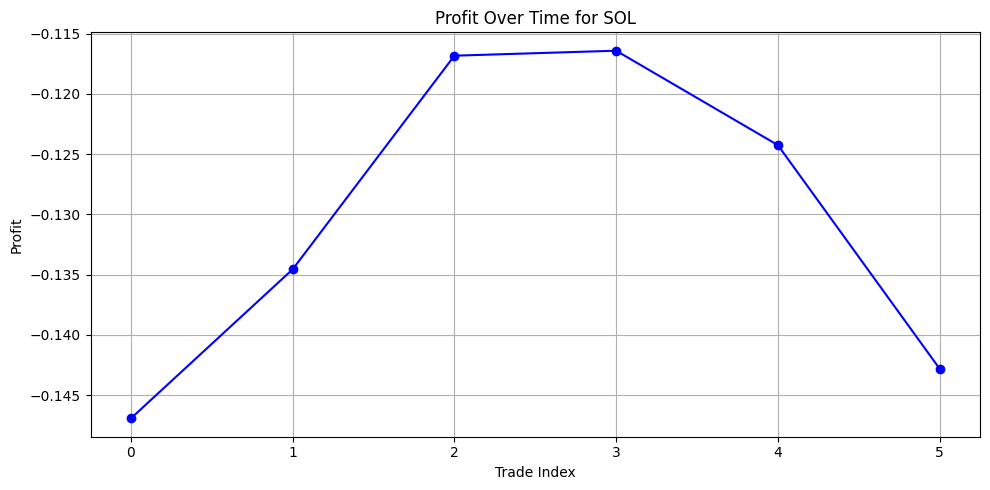

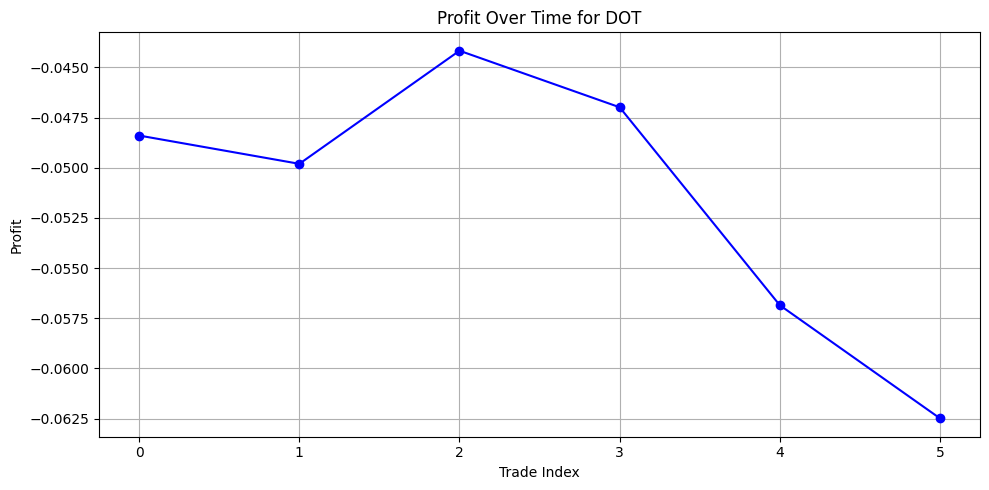

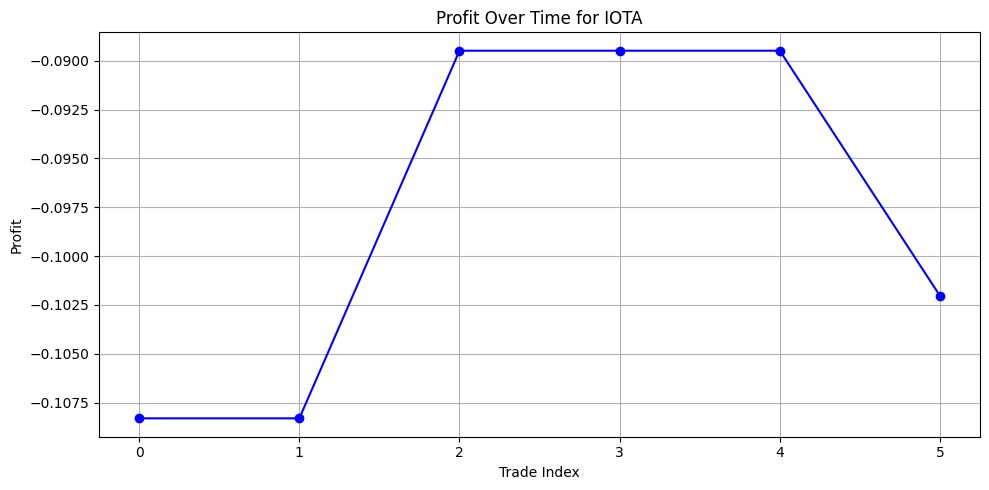

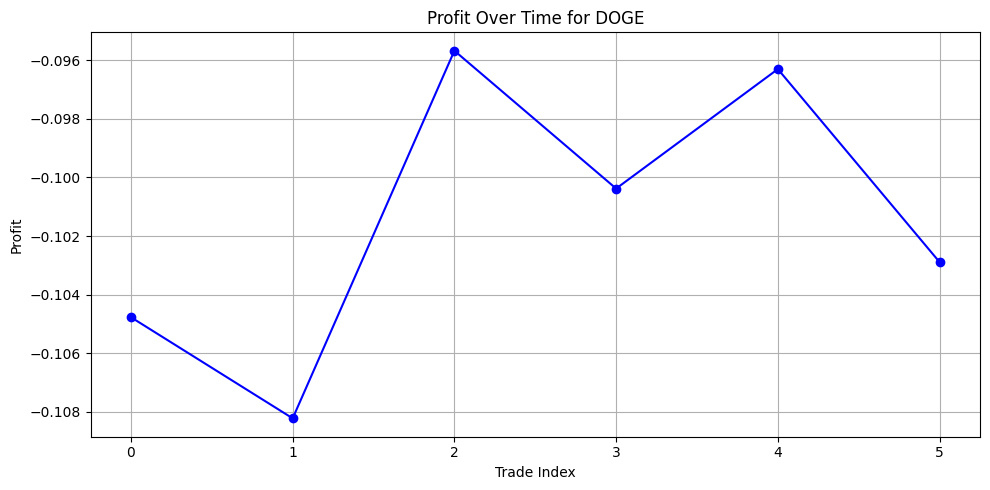

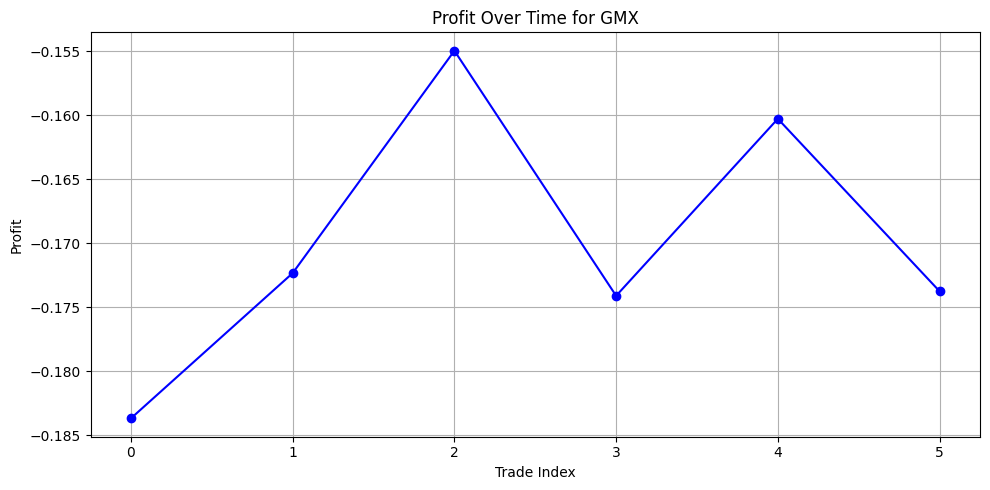

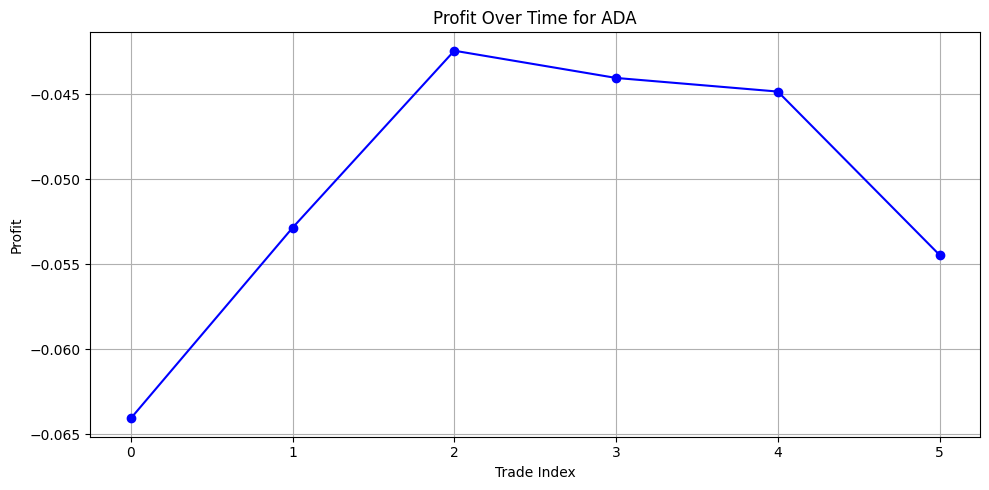

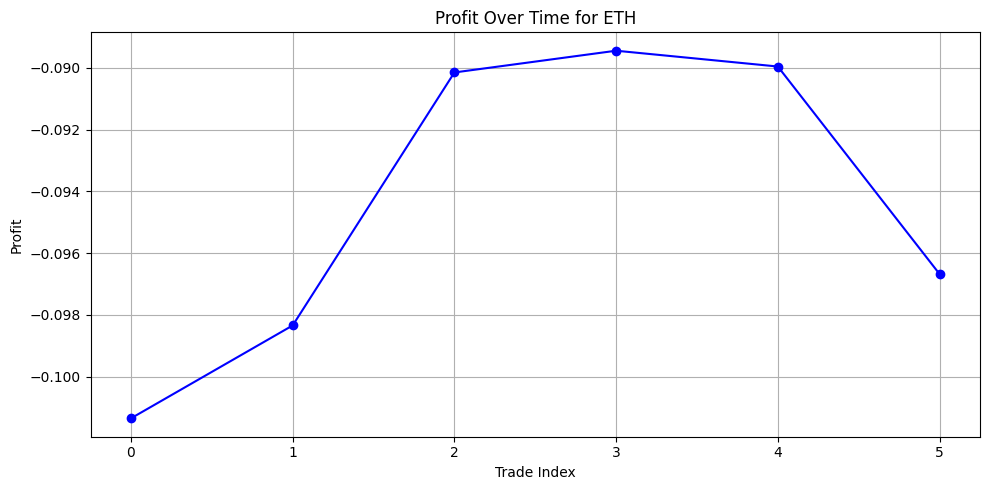

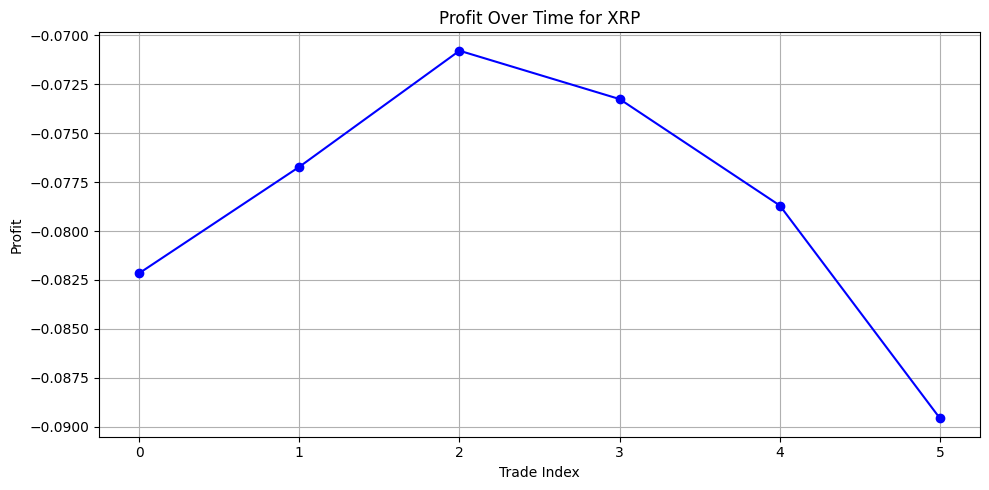

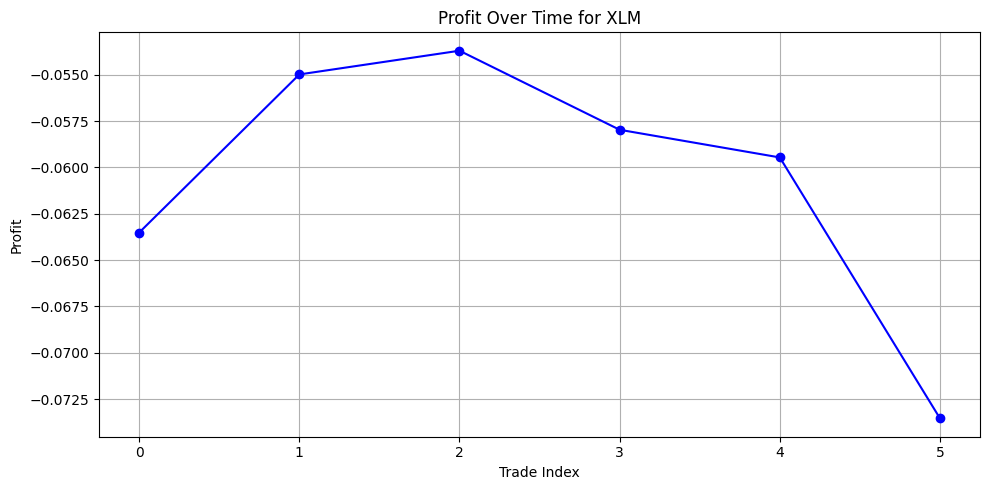

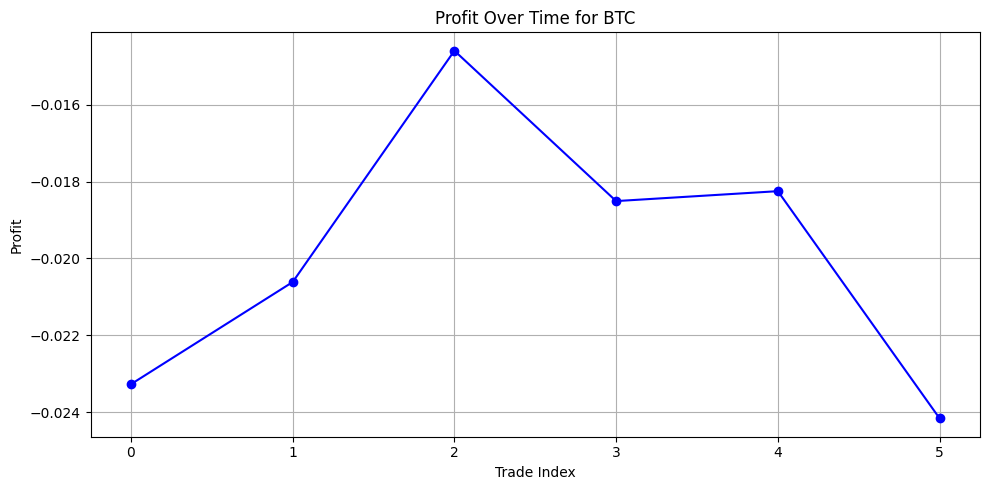

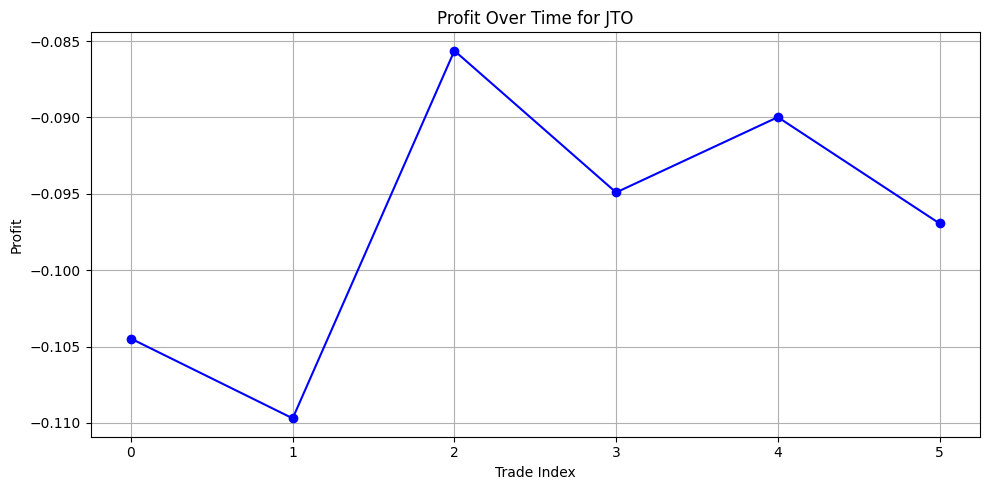

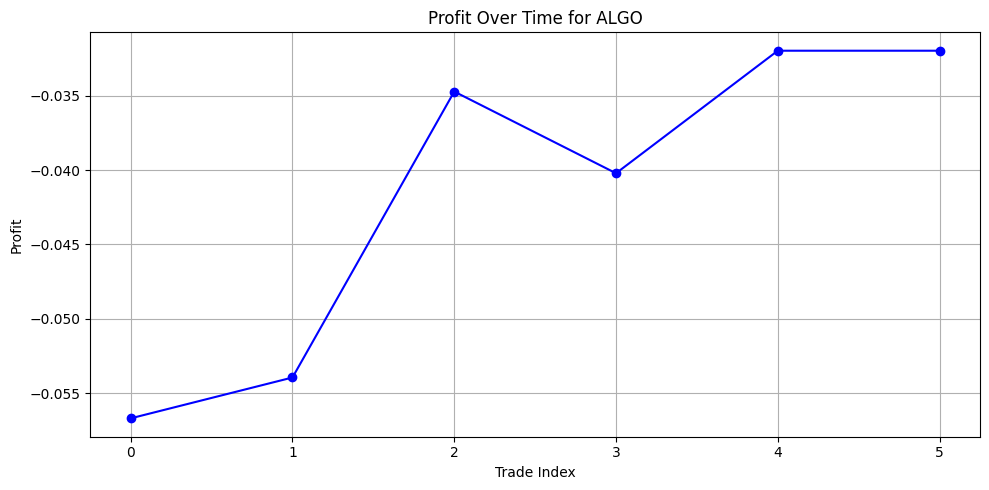

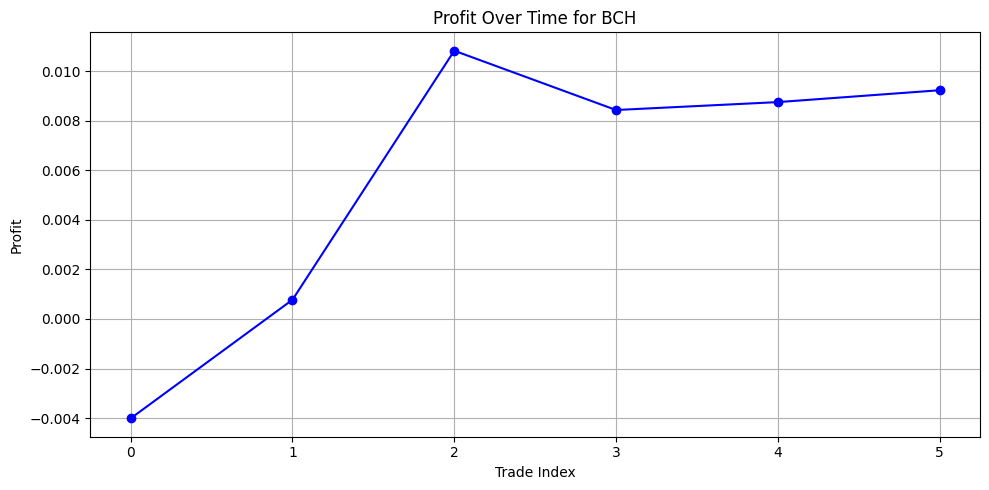

In [11]:
for x in '''SOL
DOT
IOTA
DOGE
GMX
ADA
ETH
XRP
XLM
BTC
JTO
ALGO
BCH'''.split("\n"):
    plot_profit(x.strip())

In [116]:


import numpy as np

def is_linear_decreasing(profits, threshold=5.0):
    if len(profits) < 2:
        return False  # not enough data to compute a line

    x = np.arange(len(profits))
    y = np.array(profits, dtype=np.float64)

    # Fit linear regression line: y = mx + c
    m, c = np.polyfit(x, y, 1)
    y_fit = m * x + c

    # Check if slope is negative (i.e., decreasing)
    m = round(m,2)
    if m >= 0:
        return False

    # Calculate deviation from the line
    deviation = y - y_fit
    deviation = np.round(deviation, 2)
    std_dev = np.std(deviation)

    if std_dev == 0:
        return True  # perfectly linear

    # Count how many points deviate more than one std deviation
    outliers = np.abs(deviation) > std_dev
    percent_outliers = np.sum(outliers) / len(profits) * 100

    return percent_outliers <= threshold



In [117]:
import matplotlib.pyplot as plt

def plot_array(values, title):
    plt.plot(values)
    valid = is_linear_decreasing(values)
    plt.title(title + " - " + str(valid))
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.grid(True)

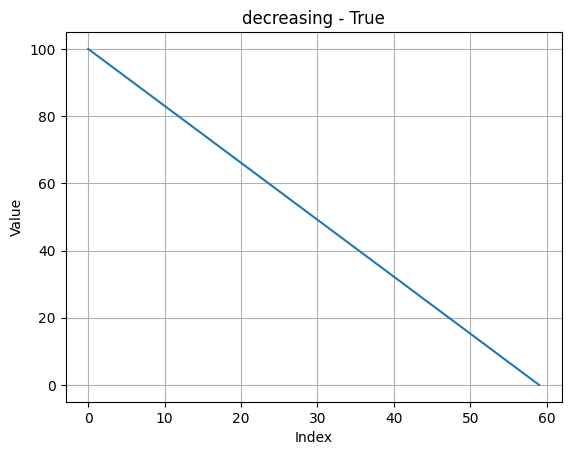

In [118]:
def equal_decreasing(start: float = 100, end: float = 0, count: int = 60):
    return np.linspace(start, end, count).tolist()
    
def equal_increasing(start: float = 0, end: float = 100, count: int = 60):
    increasing = np.linspace(end, start, count)[::-1].tolist()
    return increasing

def equal(start = 100, count = 60):
    constant = [start] * count
    return constant

plot_array(equal_decreasing(), "decreasing")



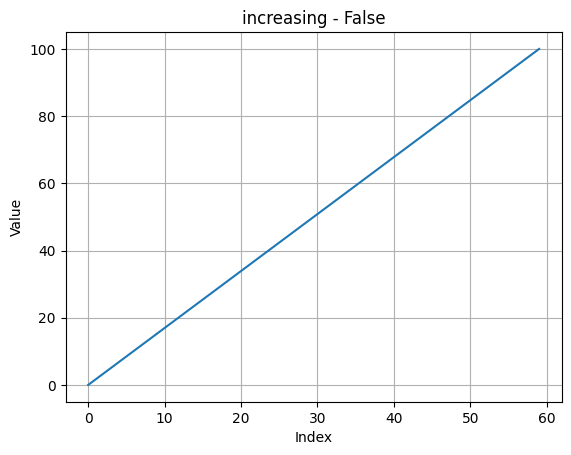

In [119]:
increasing = equal_increasing()
plot_array(increasing, "increasing")

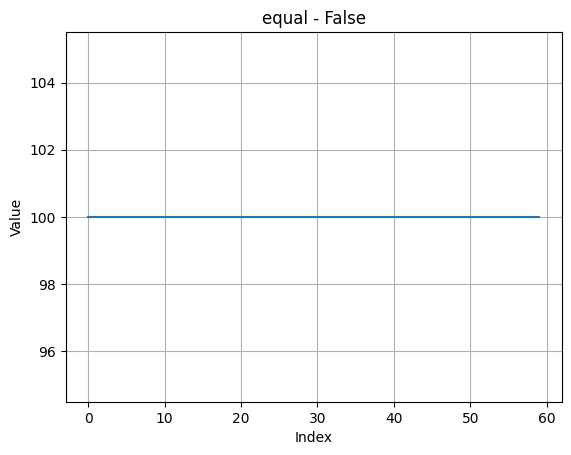

In [120]:

equal = equal()
plot_array(equal, "equal")

In [121]:
import random
def apply_deviation(values, deviation_percent, deviation_amount):
    count = len(values)
    deviation_count = int((deviation_percent / 100) * count)
    indices = random.sample(range(count), deviation_count)

    for i in indices:
        deviation = random.uniform(-deviation_amount, deviation_amount)
        values[i] += deviation

    return values

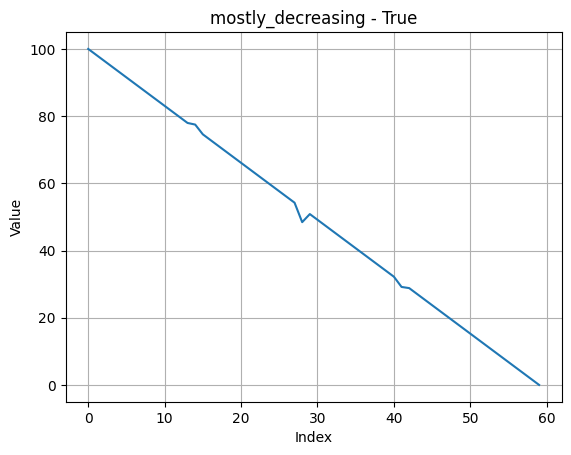

In [122]:
mostly_decreasing = apply_deviation(equal_decreasing(), 5, 5)
plot_array(mostly_decreasing, "mostly_decreasing")

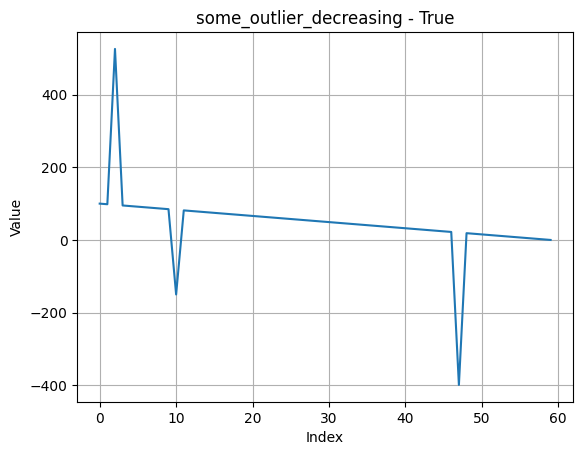

In [125]:
some_outlier_decreasing = apply_deviation(equal_decreasing(), 5, 1000)
plot_array(some_outlier_decreasing, "some_outlier_decreasing")

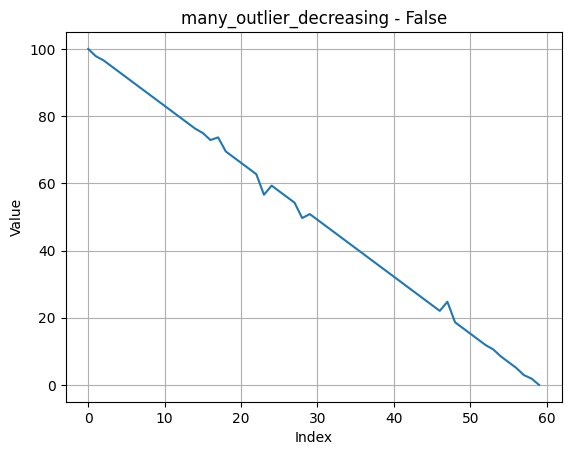

In [113]:
plot_array(apply_deviation(equal_decreasing(), 15, 5), "many_outlier_decreasing")

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 800)
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import random
from enum import Enum


import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from  ta.volume import ForceIndexIndicator
import pandas as pd

def ForceIndex(data,ndays):
    ForceIndex=pd.Series(data['Close'].diff(ndays)* data['Volume'],name='ForceIndex')
    data=data.join(ForceIndex)
    return data


def populateTrendWithForceIndex(df: pd.DataFrame) -> pd.DataFrame:
         try:
             short_window = params.macd_short_window # 6
             long_window = params.macd_long_window # 26
             signal_window = params.macd_signal_window # 9

             # Calculate the short term exponential moving average (EMA)
             df['EMA_short'] = df['current_rate'].ewm(span=short_window, adjust=True).mean()   
             # Calculate the long term exponential moving average (EMA)
             df['EMA_long'] = df['current_rate'].ewm(span=long_window, adjust=True).mean()    
             # Calculate the MACD line
             df['MACD'] = df['EMA_short'] - df['EMA_long']   
             # Calculate the Signal line
             df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()   

             # Calculate the Force Index
             force_index = ForceIndexIndicator(close=df['current_rate'], volume=df['volume'])
             df['Force_Index'] = force_index.force_index()

             # Determine the trend based on MACD
             df['Trend'] = df.apply(lambda row: 'Bullish' if row['MACD'] > row['Signal_Line'] else 'Bearish', axis=1)

             # Add Force Index signal for short or long trends
             df['Force_Trend'] = df.apply(lambda row: 'Short' if row['Force_Index'] < 0 else 'Long', axis=1)

         except Exception as e:
             self.logme(f"Exception in populateTrend {e}")
             raise e
         return df

def generate_random_number():
    integer_part = random.randint(-30, -20)
    decimal_part = random.randint(0, 9) / 10.0
    number = integer_part + decimal_part
    return number

random_numbers = [generate_random_number() for _ in range(20)]

class Constants(Enum):
    LINEAR_INCREASING = 1
    LINEAR_DECREASING = 2
    LINEAR_STABLE = 3
    PAIR = 4
    MARKET = 5
    BULLISH = 6
    BEARISH = 7 

class params():
    macd_short_window = short_window = 6
    macd_long_window = long_window = 26
    macd_signal_window = signal_window = 9
    bearish_partial_threshold_pct = bullish_partial_threshold_pct = bearish_threshold_pct = bullish_threshold_pct = threshold = 0.75
    last_trend_entries = 3
    candle_divisor = 3

def populateTrend(df) -> pd.DataFrame:
    short_window=params.macd_short_window # 6
    long_window=params.macd_long_window # 26
    signal_window=params.macd_signal_window # 9
    # Calculate the short term exponential moving average (EMA)
    df['EMA_short'] = df['current_profit'].ewm(span=short_window, adjust=True).mean()   
    # Calculate the long term exponential moving average (EMA)
    df['EMA_long'] = df['current_profit'].ewm(span=long_window, adjust=True).mean()    
    # Calculate the MACD line
    df['MACD'] = df['EMA_short'] - df['EMA_long']   
    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()   
    # Determine the trend
    df['Trend'] = df.apply(lambda row: 'Bullish' if row['MACD'] > row['Signal_Line'] else 'Bearish', axis=1)
    return df

def determineTrend(overall_result, partial_length, df):
    bullish_count = df['Trend'].value_counts().get('Bullish', 0)
    bearish_count = df['Trend'].value_counts().get('Bearish', 0)
    if bullish_count / partial_length >= params.bullish_partial_threshold_pct or overall_result == Constants.BULLISH:
        return Constants.BULLISH
    elif bearish_count / partial_length >= params.bearish_partial_threshold_pct or overall_result == Constants.BEARISH:
        return Constants.BEARISH
    else:
        return Constants.LINEAR_STABLE
            
def detectBullishOrBearishCandle(df: pd.DataFrame) -> Constants:
    
    print(f"Start Detect Overall Trend")
    if df.empty is True:
        print("Warning: Dataframe is empty in detectBullishOrBearishCandle")
        return Constants.LINEAR_STABLE   
    print(df)        
    df = populateTrend(df)
    # print(df['Trend'])
    # Evaluate the trend based on 80% rule
    bullish_count = df['Trend'].value_counts().get('Bullish', 0)
    bearish_count = df['Trend'].value_counts().get('Bearish', 0)
    total_rows = len(df)
    # print(f"bullish_count / total_rows={bullish_count / total_rows}")
    # print(f"bearish_count / total_rows={bearish_count / total_rows}")
    # if bullish_count / total_rows >= 0.7:
    if bullish_count / total_rows >= params.bullish_threshold_pct:
        overall_result = Constants.BULLISH
    elif bearish_count / total_rows >= params.bearish_threshold_pct:
        overall_result = Constants.BEARISH
    else:
        overall_result = Constants.LINEAR_STABLE
    # print(f"overall_result={overall_result}")
    # print(f"bullish_count={bullish_count}, bearish_count={bearish_count}, total_rows={total_rows}")
    print(f"Overall Result (whole dataframe) Trend: {overall_result}")
    partial_length = round(float(total_rows) // params.candle_divisor)
    if partial_length > 0 and len(df) > partial_length:
        last_partial_df = df[-partial_length:]
        first_partial_df = df[:-partial_length]
        first_partial_result = determineTrend(overall_result, partial_length, first_partial_df)
        last_partial_result = determineTrend(overall_result, partial_length, last_partial_df)
        print(first_partial_df)
        print(f"first_partial_result={first_partial_result}")
        print(last_partial_df)
        print(f"last_partial_result={last_partial_result}")
        # Check the last 3 rows
        if params.last_trend_entries > len(df):
            print(f"Last trends entries {params.last_trend_entries} is greater than candle length {len(df)} adjusting to candle length")            
            params.last_trend_entries = len(df)
        last_trends = df['Trend'].tail(params.last_trend_entries)
        if all(last_trends == 'Bullish') and overall_result == Constants.BULLISH and last_partial_result == Constants.BULLISH and first_partial_result == Constants.BULLISH:
            overall_result = Constants.BULLISH
        elif all(last_trends == 'Bearish') and overall_result == Constants.BEARISH and last_partial_result == Constants.BEARISH and first_partial_result == Constants.BEARISH:
            overall_result = Constants.BEARISH
        else:
            overall_result = Constants.LINEAR_STABLE
        print(f"End Detect Overall Trend: overall_result={overall_result}")        
        print(f"all(last_trends == 'Bullish')={all(last_trends == 'Bullish')}, overall_result={overall_result}, last_partial_result=last_partial_result={last_partial_result}")
        return overall_result    
    else:
        print(f"partial_length={partial_length} > 0 and len(df)={len(df)} > partial_length={partial_length} is false, no detectBullishOrBearishCandle")
        return Constants.LINEAR_STABLE 
            

# Step 1: Generate example data to create a Pandas DataFrame
data = {
    # 'index': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'current_profit': random_numbers
}
df = pd.DataFrame(data)

data = {
    'Close': [178,2,3,466,5,1],
    'Volume': [1,1,1,1,1,999]
}
df = pd.DataFrame(data)
n = 1
AAPL_ForceIndex = ForceIndex(df,n)
print(AAPL_ForceIndex)
# trendfi = populateTrendWithForceIndex(df)
#print (f"Force Index Trend for data {df} is {trendfi}")

exit

data = {
    # 'index': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'current_profit': 
#[-71.490000,-70.690000,-71.010000,-70.120000,-70.470000,-70.980000,-71.010000,-70.180000,-70.790000,-70.690000,
# -70.980000,-69.730000,-69.220000,-69.770000,-69.960000,-70.440000,-71.170000,-70.600000,-71.460000,-71.050000,
# -69.610000,-68.710000,-68.260000,-68.100000,-67.430000,-66.090000,-65.580000,-64.170000,-61.350000,-62.150000,
# -62.030000,-60.940000,-60.110000,-60.710000,-58.600000,-57.320000,-56.650000,-55.660000,-56.240000]
    
#[  3.230000,  2.410000,  3.640000,  6.010000,  5.190000,  4.770000,  7.250000,  5.800000,  5.190000,  4.360000,  
# 4.050000,  1.890000,  2.100000,  0.140000,  0.040000, -0.890000, -2.120000, -2.840000, -2.020000,  0.660000, 
# -0.890000, -0.680000, -3.260000, -7.270000, -7.170000, -4.080000, -2.430000, -4.590000, -5.830000, -4.280000, 
# -2.950000, -5.010000, -6.960000, -7.890000, -9.840000, -10.200000,-11.180000,-12.730000,-13.740000,-14.450000]

#[  3.230000,  2.410000,  3.640000,  6.010000,  5.190000,  4.770000,  7.250000,  5.800000,  5.190000,  4.360000,  
# 4.050000,  1.890000,  2.100000,  0.140000,  0.040000, -0.890000, -2.120000, -2.840000, -2.020000,  0.660000, 
# -0.890000, -0.680000, -3.260000, -7.270000, -7.170000, -4.080000, -2.430000, -4.590000, -5.830000, -4.280000, 
#3 2.950000, 5.010000, 6.960000, 7.890000, 9.840000, 10.200000,11.180000,12.730000,13.740000,13.740000]
    
#[-677.879129,-677.804067,-679.371143,-679.914871,-679.683487,-679.436560,-676.812873,-675.292933,-671.979721,-671.979721,-667.038193,
# -665.963390,-666.792376,-664.556294,-658.237464,-657.162402,-656.740933,-650.740933,-651.740933]

#[-29.720000,-27.960000,-28.670000,-28.150000,-31.590000,-29.610000,-30.510000,-31.710000,-30.550000,-26.230000,-23.240000,-19.900000,-15.590000,-14.800000,-10.760000,-13.040000,-15.330000,-10.940000, -3.110000, -7.380000, -6.560000, -3.860000, -4.910000, -8.990000,-11.280000,-12.930000,-15.030000,-18.550000,-19.190000,-18.440000,-14.770000,-13.270000,-13.040000,-14.280000,-16.380000,-14.020000, -5.210000,-10.420000, -7.080000, -4.310000]
#[-21.430000,-25.450000,-26.500000,-26.850000,-27.030000,-30.520000,-28.600000,-30.870000,-33.850000,-34.550000,-37.690000,-41.720000,-42.420000,-45.220000,-44.520000,-45.740000,-48.360000,-48.010000,-50.640000,-50.990000,-53.090000,-51.860000,-52.740000,-55.540000,-55.710000,-49.760000,-46.620000,-48.190000,-47.840000,-47.320000,-46.270000,-49.060000,-47.140000,-45.040000,-42.770000,-46.790000,-46.270000,-44.690000,-50.290000,-51.860000]    
#[-677.879129,-677.804067,-679.371143,-679.914871,-679.683487,-679.436560,-676.812873,-675.292933,-671.979721,-671.979721,-667.038193,
# -665.963390,-666.792376,-664.556294,-658.237464,-657.162402,-656.740933,-658.740933]
#[-45.490000,-46.580000,-44.910000,-43.570000,-48.660000,-56.750000,-54.570000,-54.160000,-55.600000,-56.300000,-55.180000,-55.950000,-55.050000,-56.880000,-55.730000,-56.240000,-58.120000,-58.480000,-53.650000,-55.920000,-56.880000,-56.400000,-56.050000,-57.290000,-61.800000,-57.930000,-55.150000,-56.810000,-58.350000,-60.110000,-60.750000,-59.600000,-59.660000,-60.680000,-60.300000,-60.460000,-62.670000,-64.390000,-64.780000,-64.740000]
#[-61.360000,-60.210000,-59.820000,-58.290000,-59.900000,-58.670000,-59.290000,-59.060000,-59.060000,-57.900000,-56.450000,-56.750000,-56.600000,-56.910000,-56.450000,-57.600000,-60.210000,-58.900000,-60.670000,-58.670000,-57.440000,-55.830000,-57.290000,-56.750000,-56.600000,-53.910000,-53.300000,-54.600000,-53.990000,-54.220000,-54.830000,-54.220000,-54.370000,-54.220000,-53.140000,-51.610000,-51.220000,-51.150000,-51.530000,-51.150000]
# [-21.430000,-24.750000,-25.210000,-22.120000,-20.190000,-18.150000,-17.220000,-17.490000,-17.260000,-24.130000,-22.360000,-17.410000,-18.460000,-20.040000,-22.820000,-21.550000,-18.690000,-21.740000,-22.700000,-21.970000,-23.590000,-26.180000,-26.180000,-24.170000,-23.480000,-25.330000,-25.870000,-22.470000,-26.180000,-29.150000,-35.710000,-35.630000,-35.290000,-34.750000,-35.170000,-30.730000,-32.860000,-32.350000,-34.670000,-34.480000]
#[-17.560000,-16.340000,-15.450000,-15.620000,-15.890000,-15.380000,-14.670000,-15.280000,-13.550000,-13.240000,-12.190000,-12.460000,-12.770000,-11.990000,-14.090000,-14.910000,-16.270000,-16.340000,-15.960000,-16.300000,-15.790000,-16.130000,-17.150000,-16.100000,-16.880000,-17.970000,-25.920000,-29.830000,-31.150000,-42.270000,-48.860000,-36.320000,-38.430000,-36.560000,-40.360000,-39.410000,-43.350000,-39.210000,-39.550000,-38.390000]
# [-677.879129,-677.804067,-679.371143,-679.914871,-679.683487,-679.436560,-676.812873,-675.292933,-671.979721,-671.979721,-667.038193,
# -665.963390,-666.792376,-664.556294,-658.237464,-657.162402,-656.740933,-685.182712,-696.182713]
#[ 1.410000, 1.630000, 1.470000, 4.100000, 1.780000, 1.410000, 3.110000, 2.180000, 3.240000, 5.060000, 3.390000, 1.130000,-0.470000, 1.630000,-1.060000,-1.770000, 0.300000,-1.090000,-1.930000,-2.550000,-1.000000,-2.480000,-2.980000,-2.730000,-2.950000,-2.700000,-2.700000,-2.950000,-3.720000,-4.370000,-3.750000,-4.120000,-4.740000,-4.180000,-5.140000,-5.300000,-5.200000,-5.880000,-7.740000,-9.690000]
#[-1.700000,-1.300000,-2.950000,-3.780000,-4.110000,-3.350000,-3.280000,-2.270000,-1.480000,-1.910000,-1.160000,-0.510000,-0.360000, 0.140000, 0.250000,-0.800000,-0.360000,-0.360000, 0.140000,-0.220000,-2.240000,-4.290000,-3.130000,-3.310000,-1.730000,-1.300000,-2.240000,-2.240000,-2.560000,-1.770000,-0.400000, 0.570000, 0.570000, 0.610000,-0.580000, 0.540000, 0.640000,-0.440000,-0.110000, 0.610000]
#[ -9.280000, -9.960000,-13.030000,-12.780000,-13.400000,-13.890000,-11.940000,-12.350000,-12.280000,-12.010000,-13.430000,-13.920000,-13.860000,-13.670000,-12.620000,-14.320000,-15.560000,-15.500000,-14.600000,-13.330000,-12.560000,-13.490000,-12.990000,-13.300000,-13.270000,-15.100000,-13.980000,-14.630000,-14.570000,-14.510000,-16.610000,-18.840000,-20.350000,-21.740000,-21.870000,-22.670000,-24.370000,-23.440000,-23.170000,-24.250000]
#[ -1.800000, -1.770000, -2.420000, -2.240000, -2.490000, -2.160000, -2.420000, -1.950000, -3.320000, -4.110000, -4.930000, -5.010000, -5.080000, -5.510000, -8.600000, -7.740000, -7.630000, -8.640000, -6.590000, -6.160000, -6.660000, -6.630000, -7.310000, -6.700000, -6.700000, -7.020000, -8.100000, -7.670000, -7.170000, -6.480000,-10.120000,-10.040000,-10.400000,-10.480000, -9.470000, -9.790000,-10.370000,-10.190000,-10.550000,-11.880000]
#[ -9.960000,-10.290000, -9.680000, -9.650000,-10.190000,-10.100000, -9.710000, -9.330000,-10.490000, -9.900000,-10.370000,-10.930000,-10.570000,-12.030000,-12.890000,-12.060000,-12.250000,-12.800000,-13.040000,-12.380000,-12.110000,-11.960000,-12.730000,-13.360000,-13.450000,-13.410000,-13.320000,-11.940000,-13.250000,-13.050000,-12.630000,-13.690000,-14.370000,-14.830000,-15.400000,-14.870000,-14.380000,-14.220000,-14.480000,-14.290000,-13.660000,-14.100000,-13.080000,-13.100000,-13.880000,-14.570000,-14.470000,-13.940000,-14.330000,-13.960000]
#[ -9.230000, -8.550000,-10.580000,-10.660000,-10.700000,-14.300000,-13.850000,-11.480000,-10.880000, -9.980000, -9.790000,-11.150000,-10.320000,-10.360000,-10.020000, -9.570000, -9.490000,-13.700000,-14.570000,-15.050000,-15.240000,-13.550000,-13.960000,-14.490000,-13.030000,-12.950000,-15.690000,-15.360000,-17.460000,-14.940000,-13.780000,-13.140000,-12.870000,-12.420000,-12.950000,-12.200000,-10.580000,-10.390000, -9.910000, -9.190000]
#[24.823686,25.388164,25.147115,25.039169,25.278049,26.586395,26.661557,29.648843,33.132100,
# 35.490520,35.246542,36.211060,36.211060,36.372339,36.452689,36.632599,36.393718,
# 37.141344,37.667481,38.455728,39.611650,40.611650,41.674520,42.515019]
# [26.497399,26.837599,27.302846,26.451872,26.080558,25.165815,24.110343,23.136131,22.579909,22.781808,22.781808,22.093352,21.723537,21.392963,21.470504,21.702588,21.776851,21.776851,22.128675,22.164756,22.879899,22.678000,22.280399,22.280399]
#[-1.070000,-1.400000,-1.470000,-1.810000,-1.610000,-0.470000,-0.470000,-0.140000,-0.270000,-0.270000, 0.260000,-0.540000,-0.210000,-0.340000,-0.210000,-0.410000,-0.610000,-0.540000,-0.340000,-0.140000,-0.270000,-0.340000,-0.410000,-0.740000,-0.410000,-2.010000,-2.070000,-1.270000,-0.940000, 0.130000]
#[-1.460000,-1.310000,-0.850000,-0.400000,-0.250000,-0.330000, 0.140000, 0.140000,-0.250000, 0.220000,-0.250000, 0.680000,-0.560000,-0.250000,-0.330000, 0.370000, 0.370000,-0.330000,-0.870000,-0.710000,-0.870000,-0.330000,-0.480000,-1.410000,-1.020000, 0.140000, 0.220000, 0.840000, 0.220000, 0.840000, 0.680000, 0.450000, 0.140000, 1.070000, 1.150000, 0.760000, 0.760000, 1.070000, 2.000000, 1.530000]
#[-0.250000,-0.850000,-0.400000,-0.320000,-0.250000, 0.200000, 0.130000, 0.200000, 0.280000, 0.130000, 0.650000, 0.650000, 0.650000, 0.200000, 0.420000, 1.020000, 0.950000, 0.570000, 0.500000, 0.800000, 0.800000, 1.100000, 0.950000, 0.200000, 0.720000, 1.170000, 1.250000, 0.800000, 0.800000, 0.280000, 0.570000, 0.420000, 0.350000, 0.200000, 1.540000, 1.320000, 1.100000, 0.720000, 0.800000, 1.320000]
#[-1.230000,-1.690000,-1.460000,-0.810000,-1.270000,-1.040000,-0.810000,-1.040000,-0.580000,-0.580000,-0.130000,-0.130000, 0.560000, 0.330000, 0.560000, 0.560000, 0.330000, 0.100000,-0.130000,-1.270000,-1.270000, 0.330000, 0.100000, 0.100000,-0.130000, 0.330000, 0.790000, 1.480000, 1.480000, 1.020000, 1.020000, 1.930000, 1.480000, 1.700000, 2.160000, 1.700000, 2.160000, 2.160000, 2.390000, 2.620000]
#[ 8.204007, 8.204007, 7.127946, 6.988875, 6.763298, 6.991384, 6.813473, 5.163698, 5.163698, 5.163698, 4.234403, 4.108486, 3.774273, 4.504458, 4.921669, 4.921669, 4.921669, 5.811224, 6.518271, 6.482089, 6.784937, 7.249585,23.809031,22.806393,21.000146,20.026653,19.425114,18.968942,17.901476,16.801626,15.462896,15.563846,15.563846,18.694649,18.360437,17.822406,17.822406,17.972790,17.972790,17.616968,17.459847,18.002576,17.699727,17.622286,23.176267,23.510480,23.126173,22.987102,22.911910,23.139996,23.317907,22.453739,22.707012,20.183275,20.493040,33.391207,33.056995,32.826410,32.409199,31.807660,31.579574,31.045841,31.438644,29.448640,28.842943,28.145971,21.909441,22.744973,23.744173,24.856737,24.555967,25.468311,26.357866,27.536276,28.115187,27.206641,27.361524,17.025934,16.691721,18.421106,18.977388,19.804504,20.032590,20.566323,21.666173,22.534538,22.736437,23.433409,42.621630,43.290056,44.519840,45.215192,45.666347,46.122519,47.189985]
#[176.206976,176.652148,177.163453,177.941892,178.071840,177.512244,177.453987,176.884835,179.798549,182.027257,182.398788,182.398788,182.602107,186.444089,205.003013,202.763379,202.281962,201.438869,204.051913,203.874984,203.861590,201.238769,197.901155,197.272606,196.598986,197.405863,197.825695,210.412868,223.514305,224.200171,227.982597,228.964794,230.343223,234.183726,232.882527,234.534865,236.098810,235.739263,235.625909,234.141933,234.827658,233.542363,229.656318,225.205549,221.393454,217.875852,217.059438,216.980720,220.206689,221.700091,224.475691,223.705129,223.631658,223.575021,222.268384,220.893144,220.611257,220.611257,220.611257,220.611257,220.611257,220.611257,220.611257,220.611257,220.611257,220.611257,220.611257,221.164116,221.399022,222.834517,222.341665]
#[ -2.430000, -2.810000, -1.400000, -3.110000, -2.840000, -1.320000, -1.560000, -1.080000, -1.550000, -0.650000, -0.870000, -0.840000, -1.320000, -1.380000, -1.490000, -3.170000, -2.720000, -3.310000, -2.480000, -2.960000, -3.510000, -4.210000, -3.700000, -4.040000, -4.620000, -4.520000, -5.540000, -5.580000, -5.670000, -5.970000, -6.090000, -6.130000, -6.500000, -7.090000, -6.400000, -6.760000, -5.900000, -4.890000, -4.870000, -4.100000, -5.210000, -8.660000, -8.220000, -8.940000, -8.810000, -8.280000,-10.110000]
#[-12.001889,-10.727526, -9.803508, -8.249126, -7.732784, -6.738881, -4.859821, -4.051396, -3.523960, -3.147898, -3.121001, -2.981071, -2.673065, -3.153095, -3.203470, -2.954994, -2.954994, -3.248967, -2.897343, -2.671706, -2.289177, -2.019312, -1.942311, -1.507998, -1.561172, -1.561172, -1.185360, -1.038373, -0.862561, -0.862561, -0.793825, -0.823810, -0.361802,  0.141087,  0.297809,  0.297809,  0.861527,  1.522966,  1.874590,  2.506374,  2.870971,  3.210801,  3.749812,  3.384075,  3.428852,  3.925804,  4.113710,  4.481176,  4.481176,  4.721855,  4.396108,  4.376118,  4.684124,  5.575608,  5.533629,  5.285154,  4.909342,  4.468382,  4.116758,  4.222055,  4.162285,  4.407163,  4.407163,  4.338587,  4.380566,  4.380566,  4.756378,  4.756378,  4.756378,  4.651081,  4.552460,  4.172650,  3.556638,  3.145184,  2.992660,  2.247233,  1.119797,  0.458358,  0.106734, -0.058733, -0.217124, -0.257104, -0.257104,  0.931542,  0.963725,  1.212201,  1.400107,  1.179627,  1.179627,  0.999118,  0.774980,  0.779977,  0.625974,  1.334590,  1.369572,  1.121097,  1.121097,  1.047603,  1.223415,  1.418968,  1.129083,  1.159068,  1.159068,  1.341936,  1.357328,  1.108853,  0.920947,  0.773960,  0.598148,  0.598148,  0.678838,  0.453950,  0.453950,  0.408233,  0.369053,  0.120577, -0.443141, -0.737114, -1.264550, -1.430017, -0.999672, -0.899722, -1.284730, -2.244790, -2.471476, -2.719952, -2.532046, -2.458553, -2.106929, -1.505230, -1.621781, -2.116534, -2.963550, -3.695024, -3.890926, -4.139402, -4.515214, -4.809187, -4.984999, -5.030126, -5.143689, -4.978772, -4.670766, -5.607967, -5.267937, -5.019462, -4.831556, -4.243610, -4.243610, -4.048057, -3.683460, -3.288657, -3.365659, -3.411376, -3.482740, -3.482740, -3.858552, -4.740471, -4.740471, -4.920981, -5.049486, -5.034494, -5.111495, -4.860051, -4.931416, -5.179891, -4.804079, -4.583600, -4.583600, -4.403090, -4.334354, -4.024509, -4.563520, -5.249277, -5.392005, -5.640481, -6.204199, -6.792145, -7.143769, -7.504788, -8.233983, -9.173513, -9.789525, -9.583798, -9.877651,-10.374603,-11.126227,-11.420200,-11.771824,-11.877121,-11.883098,-12.048015,-12.048015,-12.048015,-12.048015,-12.296491,-12.484397,-13.072343,-13.599779,-13.990884,-14.600539,-15.395141,-16.011153,-15.645416,-15.846915,-16.095391,-16.283297,-16.209804,-16.209804,-16.360228,-16.112182,-15.792342,-15.561338,-15.469904,-15.425126,-14.928175,-14.928175,-14.634202,-14.634202,-14.589074,-14.777350,-15.187145,-15.418150,-15.966755,-16.047915,-16.047915,-15.672103,-15.231143,-15.055331,-14.950034,-14.770723,-14.320948,-14.089944,-13.724207,-13.389774,-12.892823,-12.329105,-11.814652,-11.814652,-11.273123,-11.072893,-11.042908,-11.042908,-11.180060,-11.180060,-11.677011,-11.864917,-12.011904,-11.836091,-11.520200,-11.490314,-11.345387,-10.652374, -9.852324, -9.592054, -9.095103, -8.719291, -7.837372, -7.485748, -7.440620, -7.587057, -7.741980, -8.203988, -6.969626, -7.397812, -7.894763, -8.270575, -8.270575, -8.622199, -8.802709, -8.802709, -8.847686, -8.847686,-10.013473,-10.273743,-10.770694,-10.958600,-11.473053,-12.176301,-12.447066,-13.029824,-13.609534,-13.840539,-13.726246,-13.874572,-13.874572,-13.874572,-12.845666,-12.142418,-11.691144,-11.189075,-10.264538, -9.263518, -8.326317, -7.968096, -7.222669, -6.658951, -6.438472, -6.262660, -6.021980, -5.791865, -5.666928, -5.666928, -6.421260, -6.491225, -6.739701, -6.927607, -6.854114, -6.854114, -6.944369, -7.129656, -7.554443, -7.862449, -7.953884, -8.179171, -8.427647, -8.803459, -9.685377,-10.037001,-10.503318,-10.924697,-11.079620,-11.541629,-11.495912,-11.560279,-12.057231,-12.433043,-13.094482,-13.270294,-13.270294,-13.467535,-13.942298,-14.173302,-14.744766,-14.929474,-14.680998,-14.680998,-14.754492,-14.754492,-14.604067,-14.666825,-14.202058,-13.817051,-14.068495,-14.068495,-14.068495,-14.068495,-13.995001,-14.170814,-14.215941,-13.797550,-13.102898,-12.332883,-12.401459,-12.139790,-11.642838,-11.079120,-11.152613,-10.976801,-10.675952,-10.876182,-10.551344,-10.705347,-10.865357,-10.984298,-11.232773,-10.669055,-10.522069,-10.346257,-10.135662, -9.866697, -9.117072, -8.501060, -8.203898, -8.020590, -7.523639, -7.523639, -7.670625, -7.670625, -7.580370, -7.744738, -7.684768, -7.915773, -8.350085, -8.422849, -8.422849, -8.422849, -8.422849, -8.247037, -8.307207, -7.957552, -7.957552, -7.649546, -6.278032, -6.257042, -6.008567, -5.444849, -4.856903, -4.329467, -4.570146, -4.570146, -4.775044, -5.083050, -5.723090, -5.723090, -6.220041, -6.595853, -6.816333, -6.992145, -6.992145, -7.258122, -7.567967, -7.182959, -6.977232, -6.676383, -6.179431, -5.803619, -5.656633, -5.305009, -5.019202, -4.379662, -4.189757, -4.035754, -4.172905, -4.146318, -4.146318, -3.770506, -3.550027, -3.374215, -3.103450, -3.103450, -3.028488, -3.028488, -3.234215, -3.234215, -3.234215, -3.046309, -2.311376, -1.959752, -2.245559, -1.791306, -1.306549, -0.844540, -0.501662, -0.175625,  0.072851,  0.636569,  0.342596,  0.342596,  0.447893,  0.426974,  0.711831,  0.865834,  1.002986,  0.947014,  1.195489,  1.383395,  1.383395,  1.559208,  2.221076,  2.125444,  2.005504,  2.082506,  2.265374,  2.276569,  2.276569,  2.088663,  2.235649,  2.235649,  2.250692,  2.325404,  2.540297,  2.463295,  2.463295,  2.610222,  2.858697,  3.046603,  3.267083,  3.442895,  3.563235,  3.599097,  3.299247,  2.991241,  2.671221,  2.667023,  2.170072,  1.606354,  1.165395,  0.637958,  0.683086,  0.417109,  0.147244, -0.160762, -0.960812, -1.079752, -1.328228, -1.328228, -0.960762, -0.960762, -1.833225, -1.839202, -1.859192, -1.936194, -1.821901, -1.999612, -1.751136, -1.939042, -2.012536, -2.012536, -2.584150, -2.838173, -2.838173, -3.069177, -3.983520, -4.056283, -4.056283, -4.244189, -4.611656, -4.787468, -4.757383, -4.703590, -4.648617, -4.648617, -4.008577, -4.009976, -4.009976, -4.197882, -4.271376, -4.271376, -4.707607, -4.770366, -4.755374, -4.678372, -3.741171, -3.858712, -3.858712, -3.858712, -3.932205, -4.108017, -3.897423, -4.202250, -4.477113, -4.862120, -5.890756, -6.173414, -6.421890, -6.985608, -7.647047, -7.998671, -8.239351, -9.243488,-10.462878,-11.155892,-11.521629,-12.172303,-13.166206,-14.105736,-14.473202,-15.176450,-15.627725,-15.720368,-15.750353,-16.366365,-16.503517,-16.753991,-17.250943,-17.626755,-18.582167,-19.109603,-19.440537,-19.936629,-20.201497,-20.509503,-20.440927,-20.482906,-20.234430,-20.422336,-19.981377,-19.629753,-19.464285,-19.464285,-19.259388,-19.336389,-19.473541,-19.565895,-19.565895,-19.565895,-19.712881,-19.888693,-19.918778,-20.053261,-20.303136,-19.918128,-19.689543,-19.584595,-19.336120,-18.960308,-18.445855,-18.094231,-17.958849,-17.477699,-17.157859,-17.003856,-17.049573,-17.014591,-16.517640,-16.705546,-17.219998,-17.571622,-17.496410,-17.568134,-17.673082,-17.673082,-17.833091,-17.737939,-17.986415,-17.986415,-17.618949,-17.618949,-17.348184,-17.106115,-17.001168,-16.847165,-16.801448,-16.858819,-16.858819,-17.234631,-17.455111,-17.455111,-17.364856,-17.448534,-17.668424,-17.976430,-18.022147,-17.964776,-18.213251,-18.401157,-18.768623,-19.120248,-19.120248,-19.036569,-19.276449,-19.661457,-19.684315,-19.663326,-19.911802,-20.099708,-19.952721,-19.952721,-19.952721,-19.919848,-19.415100,-19.338099,-19.475250,-19.541017,-19.541017,-19.728923,-19.728923,-19.728923,-19.879348,-20.148313,-20.013381,-18.858359,-18.652632,-18.557479,-17.563576,-16.248234,-16.101248,-15.222188,-15.222188,-15.255061,-15.874751,-16.336760,-16.542487,-16.741188,-17.238139,-17.801857,-18.095830,-18.623266,-18.758648,-18.749683,-18.514800,-19.053811,-19.236679,-19.163916,-19.412391,-19.976109,-20.564055,-20.915679,-21.126274,-21.290642,-21.620477,-21.851481,-21.531461,-21.574840,-21.574840,-21.386934,-20.945974,-20.770162,-20.394100,-20.044445,-20.029453,-19.798448,-19.775590,-19.762996,-19.266045,-18.702327,-18.849313,-18.497689,-18.136670,-18.061957,-17.832072,-17.909073,-17.771922,-17.652982,-17.901457,-18.089363,-18.162857,-18.162857,-17.937219,-17.757909,-17.687944,-17.918949,-17.758939,-17.816310,-18.313261,-18.689073,-18.909553,-19.261177,-19.577069,-19.577069,-19.242237,-19.242237,-19.905135,-19.926124,-19.926124,-19.738218,-19.517739,-19.341927,-18.604845,-18.855880,-18.795910,-19.103916,-19.218209,-19.318958,-19.567434,-19.943246,-20.090232,-20.441856,-20.682536,-20.888743,-20.888743,-21.812761,-22.087063,-22.141636,-22.638588,-23.202306,-23.569772,-23.569772,-23.569772,-23.560806,-23.750711,-23.288702,-23.037258,-23.056848,-23.305324,-23.305324,-23.305324,-23.481136,-23.270541,-23.076289,-23.056299,-22.902296,-23.062306,-23.035719,-23.284195,-23.284195,-23.284195,-23.108383,-23.018128,-23.113760,-23.173730,-23.173730,-23.356598,-23.356598,-23.108123,-22.920217,-22.920217,-22.920217,-22.754749,-22.769692,-22.879637,-23.341646,-23.387363,-23.553880,-23.802355,-25.305603,-25.526083,-25.877707,-25.937877,-25.800406,-25.640486,-25.948492,-25.925633,-25.759116,-25.262165,-24.322635,-24.175649,-23.824025,-23.478048,-23.277818,-23.112900,-23.189902,-23.327053,-23.301866,-23.301866,-23.677678,-23.824664,-24.000476,-24.135859,-24.479537,-24.709422,-25.402435,-26.179626,-26.371330,-26.868282,-27.244094,-27.244094,-27.419906,-27.404863,-27.219576,-26.859756,-26.320746,-26.252170,-26.211590,-25.714639,-24.963015,-24.301576,-23.774139,-23.413120,-22.979787,-22.100227,-21.792221,-21.632211,-21.507673,-21.507673,-21.695579,-21.622086,-21.797898,-21.873110,-22.231731,-22.961366,-23.577378,-23.783105,-24.573709,-25.319137,-26.258667,-27.287572,-27.990820,-28.667731,-29.821294,-30.460974,-31.307991,-31.239415,-31.650809,-31.899285]    
#[-10.458405,-10.175606,-10.420484, -9.806930, -9.806930, -9.199155, -9.006251, -9.035596, -9.035596, -9.353797, -9.353797, -9.359814, -9.499744, -9.428950, -9.678625,-10.058485,-10.058485,-10.058485,-10.058485,-10.217585,-10.217585,-10.181483,-10.281433, -9.833067, -9.833067, -9.833067, -9.833067,-10.023812,-10.023812,-10.182912,-10.166421,-10.091208,-10.436036,-10.483232,-10.483232,-10.787120,-10.787120,-11.696825,-11.516215,-11.516215,-11.433757,-11.433757,-11.558694,-11.558694,-11.059344,-11.363232,-11.749039,-11.455586,-11.455586,-10.739634,-10.550728,-10.737255,-10.432408, -9.441283, -9.191608, -8.887720, -8.116106, -7.778635, -7.598025, -7.438925, -7.223033, -6.717606, -6.067931, -5.643163, -4.894138, -4.590250, -3.625733, -2.994808, -2.091760, -1.455358, -1.428372, -1.166633, -1.621405, -1.998976, -2.498327, -3.106103, -4.070620, -4.936307, -5.478136, -6.353188, -6.554088, -6.936167, -7.330969, -7.378165, -7.627841, -7.779785, -8.165592, -8.473717, -8.293108, -8.770409, -8.873857, -9.087460, -9.527240, -9.503642, -9.753317,-10.209149,-10.209149,-10.355876,-10.536486,-10.616036,-10.765961,-10.862233,-10.957185,-11.098774,-11.098774,-11.098774,-10.520064,-10.270628,-10.090019,-10.328669,-10.328669,-10.241423,-10.301393,-10.372188, -9.623162, -9.091358, -9.091358, -9.252758, -9.252758, -9.093657, -8.919744, -8.751269, -8.531379, -8.625771, -8.376096, -8.300124, -8.107221, -7.843113, -7.901154, -7.901154, -7.967121, -8.232338, -8.232338, -8.114347, -7.864672, -7.940644, -7.940644, -8.146061, -7.784842, -7.625742, -7.592758, -7.643903, -7.334058, -7.263263, -7.013588, -6.861644, -6.668740, -7.211629, -7.211629, -7.529830, -7.679755, -7.631619, -7.601634, -7.625232, -7.375557, -6.995697, -7.188600, -6.146841, -6.327451, -6.009250, -5.874318, -5.642664, -5.452759, -5.783133, -5.783133, -5.631189, -5.052479, -5.008461, -4.827851, -4.668751, -4.601285, -4.162044, -4.007122, -3.605953, -3.605953, -3.074149, -2.302535, -1.524884, -1.163664, -0.686363, -0.686363, -0.686363, -0.306553, -0.235758,  0.013917,  0.013917, -0.178987, -0.090951, -0.090951,  0.386350,  0.386350, -0.053430, -0.053430, -0.218617, -0.468292, -0.924124, -1.309931, -1.280586, -1.461195, -1.461195, -1.724214, -1.724214, -1.759196, -1.594009, -1.344334, -1.116418, -0.730611, -0.994719, -0.452890,  0.103962,  0.141443,  0.418224,  1.042912,  1.066510,  1.316185,  1.316185,  1.316185,  1.316185,  1.316185,  1.077535,  1.077535,  1.077535,  0.977585,  0.977585,  0.977585,  0.977585,  0.784681,  1.356915,  1.537524,  1.378424,  1.406910,  1.415935,  1.690798,  1.855985,  2.105660,  2.105660,  1.912757,  1.824721,  2.005330,  1.766680,  1.766680,  1.296045,  1.122342,  1.122342,  1.092997,  1.092997,  0.615696,  0.588709,  0.588709,  1.028489,  1.240873,  0.991198,  0.915226,  0.722322,  0.766340,  0.766340,  1.004991,  0.915036,  0.493847, -0.645583, -0.692780, -0.942455, -0.866483, -1.805533, -1.805533, -1.986143, -2.383894, -2.370401, -2.463664, -2.473659, -2.864923, -2.864923, -2.029231, -2.415038, -2.400366, -2.761585, -3.000236, -3.126173, -3.720955, -3.720955, -3.626562, -3.876237, -4.635957, -4.828861, -4.843533, -4.843533, -4.923084, -4.812139, -4.598536, -4.723473, -4.093938, -3.588591, -3.588591, -3.429491, -3.430990, -3.400905, -3.540835, -3.611630, -3.611630, -3.687602, -3.494698, -4.022914, -4.022914, -5.340915, -5.340915, -5.839785, -5.839785, -6.157986, -6.316906, -6.723053, -6.773028, -7.315787, -7.565462, -7.793378, -8.372088, -8.078635, -7.898025, -8.057126, -8.258025, -8.324212, -8.514117, -7.853368, -7.853368, -8.005312, -7.812408, -7.797736, -7.978345, -7.898795, -7.885302, -7.798055, -7.773068, -7.843862, -8.093538, -8.321454, -8.707261, -8.677915, -8.677915, -7.961963, -8.272308, -8.509979, -8.864802, -8.412648, -8.412648, -8.412648, -7.833937, -7.745901, -6.531139, -3.250500, -3.235828, -3.416437, -3.495988, -3.495988, -3.495988, -3.665903, -3.477117, -3.726792, -3.650820, -3.457917, -2.900355, -2.582155, -2.246323, -2.026703, -2.701365, -2.890151, -2.890151, -3.345983, -4.310500, -3.679576, -4.178386, -4.178386, -4.374788, -4.389830, -4.394828, -4.324033, -5.908751, -5.908751, -7.066172, -7.697096, -8.419535, -9.453687,-10.256296,-12.933087,-12.903741,-13.084351,-13.243451,-13.243451,-13.574386,-13.644351,-13.998324,-14.497674,-15.333366,-15.526269,-15.951776,-16.493605,-17.920292,-18.275294,-18.195334,-18.714494,-18.964170,-18.812226,-18.812226,-18.680172,-18.839272,-18.839272,-18.896244,-19.061711,-19.674454,-19.674454,-20.173804,-20.553664,-22.000221,-22.000221,-22.339931,-22.614294,-22.876033,-23.010965,-23.341340,-23.569256,-24.147966,-24.607357,-24.925557,-24.338241,-24.183319,-22.201070,-21.701720,-20.790056,-20.018442,-19.871716,-19.510496,-19.033195,-18.839302,-18.839302,-18.714365,-17.648658,-17.648658,-17.192826,-16.807019,-16.058713,-15.697494,-15.140642,-14.929248,-14.619373,-14.034666,-15.568548,-15.818223,-15.894195,-15.315485,-15.227449,-14.866230,-14.866230,-14.752287,-14.282961,-14.163021,-13.573066,-12.574366,-12.270478,-12.077575,-10.874416,-10.693807,-11.091558,-11.136535,-11.425351,-11.680223,-11.963402,-11.963402,-13.114876,-13.114876,-13.232257,-13.954696,-14.352447,-14.547349,-14.782012,-15.232616,-15.232616,-14.982941,-14.982941,-15.368748,-15.339403,-15.700622,-15.223321,-15.023921,-14.626799,-14.616804,-15.183161,-15.432836,-14.901032,-14.901032,-14.886359,-14.886359,-15.125010,-15.297424,-15.601282,-16.011077,-16.709118,-16.709118,-16.937034,-17.515744,-17.589107,-17.769717,-18.167468,-18.323390,-18.326399,-18.361381,-18.172596,-18.422271,-18.650187,-18.650187,-18.650187,-18.830796,-19.148997,-19.448847,-19.692535,-20.157303,-20.487677,-20.987028,-21.746748,-21.553844,-21.231046,-20.869826,-20.710726,-20.257952,-19.532905,-19.073135,-17.704440,-16.955414,-15.891807,-15.120192,-14.635995,-14.094166,-13.537314,-13.178994,-13.019543,-13.064521,-13.182512,-13.182512,-13.410428,-13.410428,-13.146320,-13.326930,-13.645130,-13.735085,-14.189368,-14.699113,-15.029488,-16.028188,-17.015824,-18.466698,-18.466698,-19.369747,-20.483450,-20.805788,-21.792575,-22.697122,-23.121890,-23.621240,-23.621240,-23.814143,-23.506017,-23.144798,-22.906148,-23.014094,-22.758372,-22.723389,-22.723389,-22.723389,-22.875333,-22.875333,-23.080750,-23.080750,-23.160300,-24.304228,-25.020250,-25.909805,-26.924527,-28.422578,-29.182298,-31.304236,-32.096560,-32.277170,-32.913571,-33.663196,-34.087394,-34.112382,-33.899998,-33.150973,-33.454861,-33.840668,-34.002067,-33.821457,-34.060108,-33.548864,-33.109623,-32.644856,-32.479668,-32.979019,-32.979019,-32.979019,-32.729583,-32.548974,-32.389873,-32.124506,-31.934971,-32.339768,-32.245376,-32.495051,-32.571023,-32.956830,-33.411682,-33.411682,-33.729883,-33.797349,-34.212522,-34.437409,-35.168953,-35.668303,-36.200107,-36.585914,-36.673950,-37.396389,-37.873690,-38.004125,-38.163575,-38.223545,-38.506723,-39.006074,-39.158018,-39.543825,-40.101386,-39.740166,-39.819717,-39.741756,-39.813959,-39.888922,-39.912520,-39.912520,-40.140436,-40.612120,-40.612120,-40.973339,-41.052890,-41.060386,-40.909961,-40.780026,-40.496848,-39.747823,-39.064075,-38.678268,-38.487523,-37.584475,-37.027623,-36.664805,-36.141327,-35.366714,-34.941947,-34.692272,-34.692272,-33.727754,-33.962517,-33.420688,-33.182037,-33.122067,-33.028804,-32.713961,-32.949943,-32.700268,-32.548324,-31.776710,-31.762037,-31.762037,-31.921138,-31.916640,-31.874521,-31.889514,-31.724326,-31.474651,-31.626595,-31.433692,-31.404346,-31.946175,-32.264376,-32.492262,-32.928494,-33.388264,-33.199478,-33.449153,-33.449153,-33.642057,-32.336190,-32.336190,-32.415740,-32.150373,-32.057110,-31.647315,-31.718109,-31.718109,-31.946025,-32.138929,-32.212292,-32.754121,-33.151872,-33.877509,-34.530353,-35.200018,-36.781097,-37.779797,-38.463545,-38.656448,-39.434099,-39.975928,-40.453230,-40.135389,-40.093270,-40.328152,-39.337028,-38.588003,-38.056199,-37.477488,-37.051981,-35.968323,-34.016450,-34.016450,-33.243266,-32.198789,-31.774021,-30.775321,-30.319489,-29.740779,-29.550034,-29.550034,-29.550034,-29.806406,-30.068145,-30.607875,-31.386615,-31.885965,-32.265825,-33.230343,-33.963976,-34.542337,-34.542337,-34.735740,-35.012521,-35.307374,-35.330972,-35.330972,-35.862776,-36.248583,-36.219238,-36.219238,-35.901037,-35.572701,-35.238758,-34.858948,-34.009413,-33.510063,-32.446455,-32.060648,-31.855231,-31.494012,-31.096260,-30.935841,-30.650034,-30.005356,-29.533392,-29.034042,-28.654182,-27.882568,-27.515752,-26.973923,-26.337521,-26.097641,-25.748656,-25.338861,-24.532734,-24.532734,-24.076902,-23.305288,-23.055853,-23.055853,-23.055853,-23.054353,-22.690326,-22.900221,-22.522649,-22.522649,-22.674593,-23.060400,-22.943019,-23.304238,-23.383789,-23.862049,-24.220060,-24.964688,-25.295063,-25.794413,-26.098301,-26.869915,-27.045987,-27.226596,-27.465247,-27.357301,-27.471624,-27.831444,-27.949435,-28.199110,-28.351054,-27.965247,-28.434772,-28.615382,-28.615382,-28.613882,-28.454432,-27.584867,-26.829725,-26.580050,-26.580050,-26.580050,-26.110525,-26.110525,-26.269625,-26.107706,-26.089655,-26.594403,-26.547206,-26.796881,-26.417021,-26.609925,-26.551234,-26.731844,-26.174992,-25.947106,-25.551854,-25.551854,-25.669845,-26.169195,-26.549055,-26.741959,-26.521869,-26.883088,-27.201289,-27.139820,-27.242109,-27.217121,-27.429505,-27.429505,-27.353533,-26.967726,-27.187816,-27.007206,-26.927656,-26.899170,-26.733703,-26.009065,-25.914673,-25.415322,-25.187406,-24.994503,-24.921140,-24.559920,-23.923519,-23.952004,-24.066327,-24.196262,-23.983878,-23.734203,-23.126427,-22.933524,-23.799211,-23.979820,-24.616222,-24.649206,-25.308066,-25.198121,-25.245317,-25.245317,-25.473233,-25.666137,-26.106317,-25.925707,-26.243908,-26.285887,-26.318980,-26.388945,-26.341749,-26.092074,-25.712214,-24.991095,-24.991095,-24.449266,-24.449266,-24.449266,-24.410155,-24.435143,-24.977901,-24.977901,-25.205817,-25.398721,-25.398721,-25.398721,-25.239620,-25.239620,-25.239620,-25.364558,-25.246567,-25.496242,-25.648186,-25.648186,-25.545477,-25.545477,-25.625027,-25.610035,-25.652154,-25.542209,-25.259031,-25.259031,-25.259031,-25.644838,-25.835582,-26.196801,-26.355902,-27.081539,-27.262049,-27.981689,-28.264867,-29.263567,-30.099259,-30.870873,-30.650783,-31.012003,-32.046155,-32.310023,-32.406295,-31.966515,-31.565346,-31.315671,-30.631923]
#[11.380879,10.993073,10.809965,10.824558,11.043448,11.127966,12.577241,13.288515,15.558739,15.807215,15.959819,16.153722,16.519939,16.490753,16.882057,17.165796,17.710523,17.899708,17.899708,18.396660,19.007074,20.170492,20.536709]
#[-6.130000,-4.670000,-4.670000,-4.670000,-3.930000,-2.830000,-2.830000,-3.020000,-2.830000,-2.470000,-1.920000,-2.470000,-2.470000,-2.470000,-2.100000,-1.920000,-2.100000,-0.820000,-0.820000,-1.000000,-0.820000,-0.640000,-0.820000,-0.640000,-0.820000,-0.820000,-0.640000, 0.280000, 0.100000,-0.090000,-0.450000,-0.450000,-0.640000,-0.270000, 0.100000,-0.450000,-1.000000,-0.820000,-1.370000,-1.550000,-1.550000,-2.100000,-1.740000,-1.190000,-1.000000,-0.270000, 0.650000, 0.830000, 0.460000, 0.100000,-0.090000,-0.270000,-0.090000, 0.100000,-0.450000,-0.450000,-0.450000,-0.270000,-0.090000,-0.090000,-0.090000, 0.460000, 1.380000, 1.380000, 1.560000, 1.380000, 1.740000, 2.110000]
#[ -7.059834, -6.537635, -3.958925, -2.057397,  0.562093,  2.699104,  4.705600,  4.356575,  6.671417,  8.405150,  8.976364,  9.296324,  9.721111,  9.800342, 10.361661, 10.209017, 10.026608, 10.128407,  8.778083,  8.530407,  7.957693,  7.622641,  6.623141,  6.385450,  4.023232,  3.870588,  3.870588,  3.681533,  4.067340,  4.315016,  4.610368,  4.972587,  5.927109,  6.560952,  6.560952,  7.171527,  7.718753,  8.155035,  8.926649,  9.422001,  9.699362, 10.127988, 10.962570, 11.517183, 11.774454, 12.156063, 12.520881, 12.331825, 12.965308, 12.965308, 12.965308, 12.744959, 12.575044, 12.495813, 11.981271, 11.447018, 11.082200, 11.038572, 10.459862,  9.716833,  9.118633,  8.348918,  7.469358,  6.993975,  5.426959,  5.350638,  5.533046,  5.242192,  5.049288,  4.801612,  4.963531,  5.374046,  5.853806,  5.933036,  5.488659,  5.306250,  5.306250,  4.826340,  4.440533,  4.192857,  4.179363,  4.176345,  4.111377,  3.794456,  3.630738,  3.172807,  2.807990,  2.589849,  2.204042,  1.956366,  1.421133,  1.010619,  0.241004, -0.234379, -0.210990, -0.516278, -0.698686, -1.018626, -1.983144, -2.726172, -2.880595, -3.088871, -3.148841, -3.148841, -3.312559, -3.617846, -3.800255, -3.683913, -4.069720, -4.069720, -4.066721, -4.386681, -4.976386, -5.293308, -5.831239, -6.289170, -6.836396, -6.996366, -7.382173, -7.877525, -8.310808, -8.688120, -8.942992, -8.942992, -8.662332, -9.196585, -9.378994, -8.855456, -7.698035, -7.945711, -8.098634, -8.400483, -9.055156, -9.292847,-10.088049,-10.698624,-12.337804,-12.337804,-13.302321,-13.549997,-13.930807,-14.296044,-14.690847,-14.532386,-14.625939,-14.625939,-14.261122,-13.752126,-12.980512,-12.237484,-11.564321,-11.199083,-10.694336,-10.298184,-10.017525,-10.093846,-10.276255, -9.970858,-10.742472,-10.990148,-11.086100,-11.252117,-10.982252,-10.744561, -9.996135, -9.690848, -9.508439, -9.363012, -8.977205, -8.729529, -9.710038,-10.823861,-12.602971,-13.791427,-15.451996,-17.054754,-18.331615,-19.305978,-20.849206,-22.087586,-22.339460,-22.417941,-22.862719,-22.941949,-23.245997,-22.864388,-22.864388,-22.326307,-22.326307,-21.830955,-21.679531,-21.724808,-21.924708,-22.162399,-22.162399,-22.544008,-23.091234,-23.178491,-23.178491,-22.930815,-22.855852,-22.952444,-22.947446,-23.264368,-23.545027,-23.545027,-23.909845,-23.909845,-24.488555,-24.736231,-25.037581,-25.161339,-25.371234,-25.450464,-25.450464,-25.450464,-25.450464,-25.450464,-25.836271,-25.588595,-25.552613,-25.649205,-24.829615,-24.591924,-23.983828,-24.594402,-24.959220,-25.061019,-24.482309,-25.225337,-26.154872,-28.258759,-31.472152,-33.849063,-35.416079,-37.629412,-41.277587,-42.441005,-44.755847,-46.737255,-47.399924,-47.952308,-48.679024,-48.907990,-48.907990,-48.907990,-48.321033,-48.321033,-45.146701,-45.146701,-44.195937,-42.722474,-41.425003,-40.330550,-40.199666,-37.300916,-37.300916,-36.012161,-35.311961,-35.388283,-34.878038,-34.878038,-34.492231,-34.244555,-34.407973,-34.130272,-33.630522,-33.551292,-33.551292,-33.322326,-33.176899,-34.945414,-35.008803,-35.586574,-34.856939,-33.633601,-33.633601,-33.225805,-32.736809,-32.317019,-31.920867,-31.840867,-31.840867,-32.205685,-32.002087,-31.809183,-32.056859,-32.052362,-32.480987,-33.440507,-34.074350,-35.939957,-36.841606,-37.999027,-38.742055,-39.419716,-40.343374,-41.247922,-43.070220,-44.403353,-45.624502,-47.599414,-47.599414,-49.142642,-49.885670,-50.693007,-50.693007,-51.587559,-52.776015,-52.027589,-51.722302,-52.451937,-52.626449,-52.819353,-53.314705,-53.377674,-54.874505,-54.874505,-58.042940,-58.042940,-58.937742,-59.185418,-59.185418,-59.043549,-59.113514,-57.780381,-55.701531,-55.701531,-54.737014,-53.993985,-53.619173,-53.078863,-52.094356,-51.381282,-51.451447,-51.756734,-52.186370,-51.607659,-52.350687,-52.461632,-52.995905,-53.460672,-53.222981,-52.685050,-52.837694,-52.837694,-52.837694,-52.451887,-52.451887,-52.407869,-52.422861,-53.056704,-53.711577,-53.482611,-53.665020,-51.687209,-51.880113,-51.137084,-50.975165,-50.504281,-49.949559,-49.553407,-49.389689,-49.313367,-49.495776,-49.939753,-50.930458,-51.710068,-52.343951,-56.848727,-56.848727,-57.813245,-57.565569,-58.021101,-57.711256,-57.552795,-57.248747,-57.096103,-56.548877,-53.774965,-52.670018,-50.674776,-49.124981,-48.590728,-48.590728,-47.876885,-48.069789,-49.060493,-50.347090,-54.294525,-55.388977,-55.825259,-56.403970,-56.899322,-56.570986,-56.534764,-56.354854,-56.037933,-55.897603,-55.287028,-54.739802,-55.074285,-54.440802,-52.500772,-51.097174,-49.223112,-47.559274,-44.729290,-42.947941,-42.947941,-42.875227,-40.753289,-39.267232,-40.151790,-40.417417,-41.506872,-41.506872,-40.820995,-41.039136,-40.267522,-40.019846,-39.974868,-39.971850,-40.101785,-40.101785,-40.546163,-41.080415,-41.810050,-44.951279,-46.301603,-49.878494,-50.829258,-50.805870,-51.340123,-51.887349,-51.451067,-52.029778,-52.525130,-52.772506,-52.860043,-53.275565,-53.275565,-53.041682,-53.652256,-54.199482,-54.257653,-54.643460,-54.891136,-54.891136,-55.159782,-54.814955,-54.973415,-54.973415,-54.897094,-54.897094,-54.838923,-54.838923,-54.591247,-54.246419,-53.567259,-53.082501,-53.082501,-52.614735,-52.080483,-51.350848,-51.132707,-50.058644,-50.058644,-49.902722,-49.866500,-49.353946,-49.353946,-49.517665,-49.899274,-49.899274,-49.201223,-49.201223,-49.201223,-49.181733,-49.115326,-49.100333,-49.100333,-49.217275,-49.064631,-49.247040,-49.101613,-48.715806,-48.468130,-48.144292,-47.993367,-47.168780,-47.089549,-46.808890,-46.656246,-46.656246,-46.452648,-47.417165,-48.407870,-48.608769,-48.741583,-48.821543,-49.455386,-50.696205,-50.696205,-50.878614,-50.805900,-50.420093,-50.667769,-50.669268,-50.633047,-50.947889,-50.778914,-50.778914,-50.778914,-50.778914,-50.807999,-51.193806,-51.441482,-51.516445,-51.628129,-51.273306,-51.352537,-51.960632,-51.807989,-51.260763,-51.318933,-50.354416,-51.097444,-52.113936,-54.097084,-60.138292,-60.138292,-60.465728,-62.908026,-65.826566,-67.397180,-71.641057,-73.870142,-74.120517,-74.805714,-74.925654,-75.638728,-77.065414,-77.141736,-78.783414,-79.132440,-79.711150,-79.711150,-80.043984,-80.466572,-81.176217,-82.126982,-83.693998,-84.380894,-84.380894,-83.886442,-83.693538,-83.198186,-83.363103,-83.387251,-83.182354,-82.390050,-82.600545,-83.363763,-83.363763,-83.349220,-84.313738,-84.561414,-84.465462,-84.776366,-84.996256,-85.392408,-84.597206,-83.833988,-83.395207,-83.395207,-82.430690,-82.430690,-82.555128,-82.820755,-81.886222,-81.410840,-81.153569,-81.153569,-80.241525,-79.441675,-78.862965,-79.110641,-79.067162,-78.402015,-78.402015,-77.609712,-76.253190,-74.955719,-74.226084,-73.498948,-73.498948,-73.251272,-72.640937,-72.640937,-71.499538,-71.499538,-71.218879,-70.989913,-70.442687,-70.137290,-69.365676,-68.374971,-67.670324,-67.105866,-66.456191,-67.248495,-67.178330,-67.025686,-67.572912,-67.340229,-67.918939,-68.166615,-68.291053,-68.269924,-67.825146,-66.399000,-65.112643,-64.273103,-64.090694,-63.959810,-63.381099,-62.885747,-62.587396,-61.917292,-61.417542,-61.179851,-60.992744,-60.229526,-59.135073,-58.538822,-56.802690,-56.059662,-55.810786,-54.914295,-53.799852,-53.245240,-52.707309,-53.072126,-53.072126,-53.726549,-54.112356,-53.617004,-53.708458,-54.961131,-55.460881,-57.203950,-57.718492,-59.015963,-60.279531,-60.279531,-62.401469,-64.412563,-64.412563,-64.638950,-65.828355,-66.303737,-67.262658,-67.415301,-67.415301,-66.796811,-66.796811,-66.549135,-66.207306,-66.261638,-65.691923,-65.295772,-65.857091,-66.086056,-66.086056,-66.362368,-67.712693,-68.208045,-68.432932,-68.375581,-68.935301,-69.410683,-69.784896,-69.708574,-69.890983,-69.872592,-69.872592,-70.367944,-70.567344,-70.709213,-70.374381,-70.149563,-70.149563,-69.996920,-69.814511,-69.290973,-68.133552,-67.638200,-66.935052,-65.863488,-65.408715,-64.616411,-64.756741,-64.527776,-63.980550,-63.995092,-64.380899,-64.628575,-64.541619,-64.982458,-64.982458,-64.435462,-64.435462,-64.511784,-65.059010,-65.349865,-65.928575,-66.176251,-66.518080,-66.898410,-67.792962,-68.189114,-68.586715,-69.120968,-69.485786,-69.776640,-69.969544,-69.969544,-70.354531,-70.354531,-70.384516,-70.622207,-71.487574,-71.411252,-71.046435,-71.308204,-71.501107,-71.501107,-71.639038,-71.934850,-71.809913,-71.730683,-71.964566,-72.040887,-72.040887,-71.982716,-71.982716,-71.239688,-71.263676,-70.970883,-70.151293,-69.992832,-69.571842,-68.732302,-67.820259,-67.413062,-66.641448,-66.889125,-66.559290,-66.191034,-66.221019,-66.379479,-66.894022,-66.894022,-66.711613,-66.769784,-67.155591,-67.403267,-67.817060,-68.453962,-68.354012,-67.957860,-67.630424,-67.325136,-67.025136,-67.025136,-66.446426,-65.703398,-65.581958,-64.942039,-64.652184,-64.018341,-64.673213,-64.825857,-65.008265,-66.055342,-64.705017,-64.457341,-64.169485,-63.937061,-63.562249,-63.324558,-62.552744,-61.636882,-60.819991,-60.819991,-59.855473,-59.112445,-58.880061,-58.451435,-57.966678,-57.649756,-57.486038,-57.715004,-57.715004,-58.383969,-58.769776,-59.265128,-59.455533,-60.080361,-61.054873,-61.847177,-61.917342,-61.993663,-61.993663,-61.920950,-62.306757,-62.306757,-62.506157,-62.485028,-62.325108,-62.325108,-62.395273,-62.547916,-62.730325,-62.003189,-61.122029,-61.122029,-61.134023,-61.085728,-60.745898,-60.349746,-59.928756,-59.699791,-59.517382,-59.375803,-59.375803,-59.623479,-59.744918,-60.125248,-61.254683,-61.413144,-61.600250,-62.134503,-62.681729,-62.609016,-63.187726,-63.187726,-63.480080,-63.256712,-62.412134,-61.302909,-61.677122,-60.001860,-60.001860,-59.551035,-59.551035,-59.551035,-59.715953,-59.888007,-60.057922,-60.216383,-60.286547,-60.133904,-60.133904,-60.133904,-60.133904,-60.447547,-60.447547,-60.870135,-61.444848,-62.395612,-62.559330,-62.864618,-63.959070,-64.319640,-64.319640,-64.567316,-64.688755,-64.492553,-65.871863,-67.852623,-69.372862,-71.357229,-71.539638,-73.911801,-73.911801,-75.645534,-75.261726,-74.802916,-73.288673,-71.704066,-70.581427,-69.436600,-67.977330,-66.930254,-66.351543,-65.113163,-65.081679,-65.749724,-65.749724,-65.749724,-65.235182,-65.082538,-65.082538,-65.053453,-65.053453,-64.805777,-64.483438,-63.903888,-62.794443,-62.398291,-62.328126,-62.328126,-61.780900,-61.708186,-60.743669,-60.000640,-59.101090,-58.240821,-56.226828,-54.642221,-54.114125,-54.114125,-53.019673,-51.815625,-51.815625,-51.815625,-51.952057,-52.106000,-51.947539,-51.947539,-52.321752,-52.321752,-52.139343,-51.790318,-51.790318,-51.542642,-51.530648,-51.624221,-51.749158,-51.828389,-51.968718,-51.892397,-51.892397,-52.168708,-52.361612,-52.609288,-52.625780,-52.710297,-52.495405,-52.495405,-52.986559,-53.139203,-53.321612,-53.554295,-53.168488,-52.920812,-52.706419,-52.383441,-51.903681,-51.624471,-51.624471,-51.471827,-51.289418,-51.231247,-50.845440,-51.093116,-51.380972,-51.604341,-52.523881,-52.840802,-53.004520,-52.928198,-52.563381,-52.010757,-52.203661,-51.708309,-51.483421,-50.731817,-49.992187,-49.279114,-48.141683,-48.141683,-47.776865,-47.631438,-47.052728,-46.805052,-46.836536,-46.706741,-47.066561,-47.383482,-47.968190,-48.426121,-49.155756,-49.344811,-49.730618,-50.225970,-50.425370,-51.007179,-51.007179,-51.482562,-51.693056,-51.998344,-51.451117,-51.451117,-51.451117,-50.708089,-50.295795,-50.117704,-49.612957,-49.296035,-49.249259,-49.020293,-49.202702,-49.188159,-51.088609,-51.088609,-51.809748,-52.446649,-53.511117,-54.065729,-53.972176,-54.124820,-53.760002,-53.789088,-53.403281,-53.155605,-53.136114,-52.894635,-52.734715,-51.781052,-51.781052,-51.704730,-51.522322,-51.653206,-51.653206,-51.653206,-51.911077,-52.152556,-52.242511,-52.955585,-52.651537,-53.185790,-53.368198,-53.222771,-53.415675,-53.911027,-53.467249,-52.619053,-51.154786,-49.411718,-47.938255,-48.777795,-47.500933,-47.428220,-45.884992,-44.646611,-44.522174,-43.991579,-43.991579,-43.833118,-43.622624,-43.241014,-43.459155,-43.459155,-44.230769,-44.478445,-44.742313,-44.962663,-45.572358,-46.443892,-46.630999,-47.317895,-47.500304,-47.485761,-47.485761,-47.982013,-47.982013,-48.446860,-48.981593,-49.694666,-49.320453,-49.579184,-49.579184,-49.448299,-49.641203,-49.641203,-49.357845,-48.971478,-48.296815,-47.662972,-47.405701,-47.176736,-46.629509,-46.600424,-46.986231,-46.738555,-46.533158,-46.385252,-46.125382,-45.966921,-45.966921,-45.585312,-45.402903,-45.272018,-44.693308,-44.197956,-44.404852,-44.555777,-44.935587,-44.935587,-44.678315,-44.449350,-44.631759,-44.762643,-45.148450,-45.148450,-44.997026,-44.997026,-44.892079,-44.575157,-44.551769,-44.551769,-44.734178,-44.734178,-44.348371,-44.596047,-44.417636,-44.254637,-44.149690,-44.070460,-43.789800,-43.942444,-43.760035,-43.760035,-43.760035,-44.007711,-44.235597,-44.401614,-44.901364,-45.297516,-44.595867,-44.672189,-44.854597,-44.854597,-45.433308,-45.680984,-45.706011,-45.706011,-45.825951,-45.667491,-45.480384,-44.946131,-44.763723,-44.647381,-44.647381,-44.647381,-44.657876,-44.657876,-45.452478,-45.848630,-46.620444,-47.459984,-48.007210,-48.079924,-48.851538,-49.594566,-49.258734,-48.914626,-48.464851,-47.989469,-47.194267,-45.747970,-45.442573,-45.442573,-43.706442,-42.606292,-42.606292,-41.987502,-42.009680,-42.009680,-41.658856,-41.506212,-40.776577,-40.980175,-41.558886,-41.806562,-42.139396,-44.228710,-44.228710,-44.862553,-45.891638,-46.349569,-46.714387,-46.554417,-46.747320,-46.747320,-46.877755,-46.760034,-46.790019,-46.552328,-46.786211,-46.557246,-47.104472,-47.075386,-46.882483,-46.882483,-46.924462,-46.628650,-46.168880,-45.693498,-44.687801,-44.611479,-44.429070,-44.545412,-44.931219,-45.426571,-45.254157,-45.405082,-45.934817,-46.014047,-46.364872,-47.204412,-47.751638,-47.926151,-48.311958,-48.311958,-48.389919,-48.957395,-48.832457,-48.594766,-48.243942,-48.091298,-47.726481,-47.726481,-47.726481,-47.726481,-47.234727,-46.585751,-45.856116,-44.826122,-44.662403,-43.212289,-42.482654,-41.711889,-40.168661,-39.425633,-39.277207,-39.153449,-38.863594,-39.022055,-38.413959,-38.719246,-39.091960,-39.091960,-39.670671,-39.918347,-40.231690,-40.545613,-41.140315,-42.101594,-42.101594,-42.406882,-42.954108,-43.143163,-43.721874,-44.217226,-44.544063,-44.559155,-45.018925,-45.652768,-46.401194,-46.401194,-46.583602,-46.554517,-46.940324,-46.940324,-46.764912,-46.867540,-46.877535,-46.719075,-46.391638,-45.857386,-45.857386,-45.726501,-46.112308,-46.855336,-46.744392,-46.943612,-47.018575,-47.097805,-47.214747,-47.367390,-47.732208,-47.804921,-48.383632,-48.631308,-48.292477,-47.984591,-47.994586,-47.994586,-46.548190,-46.548190,-46.548190,-47.028100,-45.484872,-45.980224,-46.173627,-46.617345,-47.162073,-47.637455,-48.385881,-48.767490,-49.132307,-49.539504,-49.925311,-49.677635,-49.769089,-49.865680,-50.560333,-50.718794,-50.625240,-50.943501,-50.943501,-50.441352,-50.441352,-49.946000,-49.760093,-49.527670,-47.603852,-47.603852,-46.715097,-45.417626,-44.505582,-43.141564,-43.141564,-42.646212,-42.422824,-42.120975,-41.551260,-41.234338,-41.351280,-41.351280,-41.168871,-41.168871,-40.783064,-40.287712,-40.112300,-39.644434,-39.124694,-38.490851,-37.999696,-37.465444,-36.735809,-36.706723,-36.128013,-35.632661,-35.052451,-34.494030,-33.514520,-32.470203,-32.470203,-31.401697,-30.672062,-30.221238,-28.678010,-27.439629,-26.703497,-26.341279,-25.261819,-24.627976,-24.253763,-23.948476,-23.036432,-22.701949,-21.544528,-21.296852,-21.124438,-20.732035,-20.277262,-20.039571,-19.525028,-19.677672,-20.224898,-19.977672,-18.820251,-19.067927,-19.073924,-19.212775,-19.667547,-19.826008,-19.592125,-19.592125,-19.592125,-19.868437,-20.447147,-20.694823,-21.711315,-23.093683,-23.093683,-23.489835,-24.168096,-24.244418,-24.974053,-25.075852,-25.075852,-24.580499,-24.697441,-24.715552,-23.031394,-22.635243,-22.261030,-22.032064,-21.849656,-21.791485,-22.177292,-22.424968,-22.733813,-22.736832,-22.791804,-23.504877,-23.879090,-24.337021,-25.320529,-25.320529,-26.725626,-26.725626,-26.707635,-26.626136,-26.416971,-26.416971,-27.843657,-27.385726,-27.203317,-27.421458,-26.842748,-26.347396,-25.905117,-25.624397,-25.259580,-25.021889,-24.367016,-24.367016,-24.367016,-24.323388,-24.902099,-25.149775,-25.497601,-26.573462,-26.573462,-26.969614,-26.969614,-27.122258,-27.304667,-27.144697,-27.144697,-26.897021,-26.645147,-26.660239,-26.615261,-26.852953,-27.367495,-27.596461,-27.961278,-28.033992,-28.612702,-29.108054,-29.108054,-29.346515,-29.611383,-29.452922,-29.476310,-29.399988,-29.035171,-28.671603,-28.285796,-28.285796,-28.152363,-28.152363,-28.152363,-28.073132,-27.745696,-27.593052,-27.228235,-27.170064,-27.170064,-26.674712,-26.800649,-26.670854,-26.820779,-26.820779,-26.820779,-27.431353,-27.431353,-27.824007,-27.438200,-27.251993,-27.251993,-27.321418,-26.676851,-26.676851,-26.513133,-26.284167,-26.284167,-24.639140,-24.639140,-24.639140,-24.699110,-24.662888,-25.072683,-25.151914,-25.198690,-25.198690,-25.016281,-24.696341,-24.696341,-24.200989,-24.012084,-23.477811,-23.131634,-23.131634,-23.131634,-22.368416,-21.456372,-21.238231,-20.080810,-19.585458,-19.990256,-19.736702,-20.771185,-21.405028,-22.050065,-22.050065,-21.867656,-22.260310,-22.453214,-23.443918,-23.265507,-22.978751,-21.574453,-20.861380,-18.616103,-18.081850,-17.717033,-17.746118,-17.360311,-17.112635,-16.751316,-16.524929,-16.055164,-15.896703,-15.569267,-14.152736,-14.152736,-13.803710,-12.839193,-12.591517,-12.381622,-12.079773,-12.309658,-12.626579,-12.930627,-13.770167,-14.317394,-14.331936,-14.524840,-14.524840,-14.334435,-14.210677,-13.680942,-13.443251,-13.443251,-13.214285,-13.214285,-13.301542,-12.915735,-13.411087,-13.534025,-13.814745,-14.329487,-15.121791,-14.607249,-15.217823,-15.582641,-15.219072,-15.990686,-16.486039,-17.132215,-17.029587,-16.939632,-16.464250,-16.557803,-16.176194,-15.811376,-15.578693,-14.064050,-14.064050,-13.725220,-13.438463,-12.983691,-12.508309,-12.134096,-11.052617,-11.052617,-10.354566, -9.582952, -9.335276, -9.155366, -8.732777, -8.632827, -8.460044, -8.460044, -8.612687, -8.065461, -7.934577, -8.320384, -8.320384, -7.713187, -6.325721, -6.325721, -6.008800, -5.704752, -5.170499, -4.805682, -4.922024, -4.922024, -4.426671, -4.569100, -4.514767, -4.199925, -3.566082, -3.332199, -3.255877, -3.438286, -3.060175, -2.674368, -2.674368, -2.495957, -2.444643, -2.344693, -2.186232, -2.396727, -2.320405, -2.320405, -2.364033, -2.749840, -2.749840, -2.793318, -3.001594, -2.801694, -2.564003, -1.475828, -1.475828, -1.293419, -1.177077,  0.173248,  0.668600,  0.728570,  1.042493,  1.207410,  1.207410,  1.605011,  1.605011,  1.787420,  1.729249,  0.764732,  0.764732,  0.680774,  0.566071, -0.343364, -0.343364,  0.007460, -0.145183, -0.145183, -0.232440, -0.425343, -0.673019, -0.185763,  0.019494,  0.309349,  0.626271,  0.369000,  0.292678,  0.110269, -0.515068, -0.707972, -1.239306, -1.239306, -1.332879, -1.732679, -2.049600, -1.792329, -2.173938, -2.538756, -2.553298, -2.939105, -3.186782, -3.134308, -3.037716, -2.587941, -2.271020, -2.692009, -2.310400, -2.127991, -1.808051, -1.615148, -1.367472, -1.399776, -1.399776, -1.504723, -1.821645, -2.991060, -2.914738, -3.097146, -3.417086, -3.224183, -3.719535, -3.694048, -3.537086, -3.786961, -3.549270, -4.250919, -4.174597, -4.357006, -4.764202, -5.342913, -5.838265, -6.058655, -6.417855, -6.587770, -7.142383, -8.031138, -8.641713, -9.371348, -9.676745,-10.255456,-10.750808,-10.743311,-10.821792,-11.266570,-11.821182,-11.680852,-11.909818,-11.909818,-12.113416,-12.113416,-11.865740,-10.855245, -9.994976, -8.575686, -6.911848, -6.163423, -5.476526, -4.382074, -4.091219, -1.583474, -0.345093,  0.939764,  1.440833,  2.420343,  3.133417,  3.437465,  3.590108,  4.319743,  4.377914,  5.149528,  5.644880,  4.445380,  4.445380,  4.455375,  4.455375,  4.408599,  4.255955,  4.620773,  4.577145,  3.612627,  3.860303,  3.800333,  4.391957,  4.676815,  4.756045,  5.593106,  5.593106,  5.957924,  5.768868,  5.190158,  4.694806,  3.654326,  3.189479,  3.199474,  2.882552,  3.022882,  2.107020,  1.377385,  1.101073,  0.908170,  0.321663,  0.321663,  0.022833, -0.047132, -0.364054, -0.831820, -0.450211,  0.826651,  0.957535,  2.472177,  2.968429,  3.710978,  4.370648,  5.242182,  5.709948,  5.786270,  6.333496,  6.202611,  6.202611,  6.450287,  6.900062,  6.993636,  6.828718,  6.749488,  6.843041,  7.377294,  7.377294,  7.580892,  7.773795,  8.269148,  8.687438,  8.808178,  9.487838, 10.121681, 10.121681,  9.969037,  9.969037, 11.325359, 11.573035, 11.522060, 11.522060, 11.347148, 11.505609, 11.669327, 12.050936, 12.415753, 12.197612, 13.162130, 13.409806, 13.954034, 15.031635, 15.491405, 15.966787, 15.990175, 16.600750, 16.251724, 16.251724, 16.830435, 17.078111, 17.415442, 17.847086, 17.907056, 18.620129, 18.573353, 19.870824, 21.037990, 22.388314, 23.131343, 23.488164, 25.063816, 27.827434, 29.384844, 29.384844, 30.148063, 30.330471, 30.214130, 31.564454, 32.555158, 31.561156, 29.870801, 28.026724, 28.264415, 27.820037, 28.201646, 28.931281, 29.018538, 27.668213, 27.915889, 27.986354, 27.633151, 27.633151, 26.523926, 26.360208, 25.520668, 25.703076, 25.208624, 25.015720, 24.520368, 24.392932, 24.266155, 23.656460, 23.735690, 25.068824, 25.679398, 26.226624, 26.401137, 28.523076, 29.266104, 29.375549, 29.526474, 29.491491, 29.570721, 28.658578, 28.582256, 28.582256, 27.658368, 27.658368, 26.667664, 26.366314, 25.964855, 25.814930, 25.656470, 25.609693, 25.533371, 25.533371, 25.576999, 24.419578, 23.924226, 23.976700, 23.590333, 23.375441, 23.692362, 23.505256, 23.276290, 22.911473, 22.969644, 24.705775, 25.201127, 26.096180, 26.337659, 26.617519, 26.696749, 26.275760, 26.352082, 26.716899, 26.396959, 25.239538, 25.239538, 25.039338, 25.039338, 25.239238, 25.635390, 27.058398, 27.058398, 27.925564, 28.890082, 29.880786, 30.607923, 31.359527, 32.132680, 32.132680, 32.389951, 32.160986, 31.613759, 31.613759, 31.227952, 31.227952, 31.182975, 30.672850, 30.662855, 31.375928, 31.656588, 31.503944, 31.503944, 32.187452, 31.222935, 29.980656, 29.980656, 29.754270, 30.029132, 30.346054, 30.668572, 30.486163, 30.137138, 29.944235, 29.201206, 29.841386, 30.568842, 32.557847, 32.716308, 32.388872, 33.610021, 34.157247, 34.215418, 36.723163, 38.456896, 38.408920, 38.113108, 37.398466, 37.240005, 36.281085, 35.594188, 35.229371, 34.676747, 33.519326, 32.776298, 32.011680, 31.456278, 31.241386, 31.162155, 31.115379, 31.115379, 31.480196, 32.779196, 32.779196, 33.274549, 33.517427, 33.635148, 33.635148, 33.872839, 33.896228, 34.583124, 34.285623, 34.285623, 33.706912, 33.706912, 32.994769, 32.656698, 31.947053, 31.630131, 31.653520, 30.737658, 30.008023, 29.993480, 29.607673, 29.112321, 29.194780, 29.526813, 30.021566, 30.338487, 30.806253, 31.569472, 32.218497, 32.218497, 33.237787, 33.597607, 34.023214, 33.258597, 32.862445, 32.301126, 32.148482, 31.418847, 31.040736, 29.883315, 28.644935, 26.225545, 26.225545, 24.691312, 23.740548, 21.495271, 20.732053, 20.184827, 19.544947, 18.773333, 18.525657, 18.822508, 18.852693, 19.042598, 19.517980, 19.494592, 18.960339, 18.689425, 18.689425, 18.441749, 18.701119, 18.556231, 18.671174, 18.671174, 18.788115, 19.017081, 18.834672, 18.660159, 17.888545, 17.640869, 17.924228, 18.144577, 17.779760, 17.653753, 17.424787, 17.424787, 17.242379, 16.947676, 16.947676, 16.700000, 16.683508, 16.439011, 16.638911, 16.480450, 16.012684, 15.936362, 15.936362, 16.154503, 15.961599, 15.961599, 16.280940, 16.619011, 16.624008, 16.069395, 15.625018, 15.243409, 15.243409, 15.999630, 16.385437, 16.880790, 16.652904, 16.652904, 16.787836, 16.946297, 16.548696, 16.548696, 16.548696, 16.548696, 16.548696, 17.291724, 17.291724, 17.720350, 17.610405, 17.768865, 18.026137, 18.102458, 18.467276, 19.179869, 19.372773, 19.125097, 18.846236, 18.339130, 17.809395, 17.175552, 16.184608, 16.184608, 15.637382, 14.706647, 14.127937, 13.384908, 13.197502, 12.886598, 12.601740, 11.730206, 10.630956,  9.638772,  8.909137,  8.603740,  7.639223,  7.143870,  7.010437,  6.853476,  6.268768,  5.555695,  5.368589,  4.986979,  4.804571,  4.804571,  4.032957,  3.537605,  3.059344,  2.654866,  2.325031,  1.215806,  0.514157, -0.096418, -1.008461, -1.488371, -1.874178, -2.121854, -2.241794, -2.667401, -2.852309, -3.565382, -3.308111, -3.460755, -3.460755, -3.678895, -4.836316, -5.579345, -6.438415, -7.739384, -8.568969, -8.410508, -8.129849, -9.427320, -9.609729, -9.249159, -9.249159, -8.506131, -7.783492, -7.016796, -6.007301, -5.769610, -6.026881, -6.026881, -6.391698, -6.217186, -5.059765, -5.307441, -5.118535, -4.991759, -5.176666, -5.255897, -4.741354, -4.665032, -4.665032, -4.762983, -4.762983, -4.267631, -2.233848,  0.040014, -0.514598, -0.421045, -0.802654, -0.985063, -1.188661, -0.995758, -1.986462, -6.232518, -6.232518,-11.314975,-11.711127, -9.395686, -8.021893, -7.292258, -6.666921, -6.859824, -6.364472, -7.490409, -9.992737,-11.481992,-14.462281,-14.462281,-16.370327,-17.279872,-17.279872,-17.665679,-17.170326,-15.296264,-12.649048,-10.340203, -8.993287, -6.139914, -4.537156, -3.625112, -3.261544, -2.297027, -2.049351, -1.833459, -1.431999, -0.457487,  0.017895,  1.140534,  2.285361,  3.379813,  3.699753,  5.435885,  6.178913,  6.997504,  7.643461,  8.827868,  9.778632,  9.755244,  9.831566,  9.831566,  9.831566, 10.217373, 10.181391,  9.979152, 10.543870, 11.494634,  9.951006, 10.027328,  9.844919,  9.743120,  9.164410,  8.421381,  8.352416,  7.612886,  5.988698,  4.166400,  3.792187,  3.028969,  3.028969,  2.665401,  2.279594,  2.031918,  1.160853,  1.399314,  1.679174,  2.159814,  2.159814,  1.778205,  0.501343,  0.341373, -0.044434, -1.679716, -1.679716, -2.074518, -2.549900, -2.737007, -2.813328, -2.630920, -3.023573, -3.602284, -3.602284, -3.359405, -3.428831, -3.513788, -3.355327, -3.308551, -3.155907, -3.338316, -3.236517, -2.850710, -3.098386, -3.206332, -3.773808, -4.828280, -5.699814, -6.284522, -6.971418, -7.701053, -7.948280, -8.912797, -9.160473, -9.259424, -8.892607, -8.892607, -9.130298, -9.668229, -9.897195,-10.262012,-10.494696,-11.266310,-11.761662,-12.190448,-13.376714,-14.286259,-14.999332,-15.607428,-16.370646,-16.735464,-16.997233,-17.383040,-17.878392,-19.779441,-21.394333,-23.428316,-25.329845,-26.756531,-28.359289,-29.636150,-30.828654,-33.143496,-33.886524,-34.423256,-34.341756,-34.056899,-33.264595,-33.241207,-33.317529,-33.682346,-33.653261,-35.196489,-36.434869,-35.983595,-37.305694,-38.005344,-40.065333,-41.842844,-42.758706,-43.670749,-43.379895,-42.801184,-42.553508,-41.983793,-41.075228,-40.220655,-39.428352,-38.375878,-37.994269,-37.629452,-37.353140,-37.353140,-37.353140,-37.000816,-37.070241,-37.589981,-37.986133,-38.898277,-38.974599,-39.704234,-40.155058,-41.698286,-43.184343,-44.547161,-45.857186,-47.611308,-48.958224,-49.846980,-50.991807,-51.174216,-50.461622,-49.497105,-49.001753,-49.025741,-48.376765,-48.041933,-48.041933,-47.496606,-47.496606,-46.949379,-46.963922,-47.735536,-48.230888,-48.302852,-48.480943,-48.550908,-47.758605,-47.010179,-46.170639,-44.893778,-44.573838,-43.609320,-42.866292,-42.334058,-41.564343,-41.099576,-40.624194,-40.366922,-40.290600,-40.837827,-40.605143,-41.183854,-41.679206,-42.127482,-42.691939,-43.421574,-44.293108,-44.947981,-46.016486,-46.746121,-46.804292,-46.997195,-46.997195,-46.709339,-46.063383,-45.773528,-44.901994,-44.364063,-43.829810,-42.735357,-42.633558,-41.118916,-41.118916,-40.658646,-39.529731,-38.440276,-37.964894,-37.333410,-36.341226,-34.881956,-34.329333,-33.557719,-33.557719,-33.703146,-34.104605,-34.634340,-35.503515,-35.961446,-36.508672,-36.450501,-36.836308,-37.331661,-37.202725,-37.887922,-38.602565,-39.157177,-40.162874,-40.773449,-41.138266,-41.530920,-41.476147,-41.476147,-41.498636,-40.849661,-40.274948,-40.195718,-40.342205,-40.707022,-40.837907,-41.732259,-42.332939,-42.352929,-42.115238,-41.787801,-41.329871,-40.898986,-40.898986,-40.898986,-40.841575,-40.771410,-40.847732,-41.759775,-42.428741,-42.814548,-43.062224,-43.191159,-43.447731,-43.812549,-44.446391,-45.311759,-46.074977,-46.804612,-47.589919,-49.159334,-49.912537,-49.912537,-50.487250,-51.121092,-51.354975,-51.736585,-52.101402,-52.101402,-52.680113,-51.937084,-51.437834,-50.945820,-50.211188,-49.418884,-48.764012,-47.012428,-46.241663,-44.505532,-44.257856,-43.955007,-43.743713,-43.578795,-43.103413,-43.080025,-43.003703,-42.821294,-42.617696,-43.196407,-43.196407,-43.665672,-44.012798,-44.367621,-44.843003,-45.591429,-46.278325,-46.278325,-46.976376,-46.783472,-46.783472,-46.318805,-46.273827,-46.511518,-46.862343,-46.786021,-46.786021,-47.062333,-47.255236,-47.502912,-47.753287,-47.720084,-47.590149,-47.431688,-47.338135,-47.338135,-47.469019,-48.047730,-48.047730,-48.071718,-48.029459,-48.209369,-48.526291,-48.900503,-48.900503,-49.155626,-49.155626,-49.982012,-49.982012,-49.904051,-49.858774,-50.218594,-50.218594,-52.229988,-51.619413,-51.072187,-51.595725,-51.595725,-51.100373,-51.320763,-51.427849,-51.269388,-51.947649,-51.947649,-52.151247,-52.151247,-52.344151,-52.591827,-52.662291,-52.900752,-53.005700,-53.401852,-53.448628,-53.677594,-53.860002,-53.990887,-54.569597,-55.064950,-55.547708,-55.792206,-55.957123,-56.432505,-56.362341,-56.286019,-56.468427,-56.730196,-56.923100,-56.923100,-56.779172,-57.014214,-57.014214,-57.251906,-57.633515,-57.633515,-57.815923,-57.859552,-58.245359,-58.493035,-58.430066,-58.354604,-58.569496,-58.331805,-58.191475,-58.038832,-58.038832,-58.184259,-58.431935,-58.799251,-59.372765,-60.252325,-61.361550,-62.601130,-63.898600,-64.810644,-65.479610,-67.022838,-68.261218,-69.619539,-70.211163,-70.815860,-71.608164,-71.982377,-72.592951,-73.687404,-74.254570,-75.219087,-75.962116]    
#[ 7.130000, 6.330000, 6.260000, 6.470000, 5.620000, 6.920000, 6.870000, 7.030000, 4.700000, 3.990000, 4.600000, 6.040000, 6.260000, 6.230000, 6.800000, 6.820000, 6.520000, 5.760000, 5.410000, 4.670000, 5.360000, 5.710000, 6.000000, 5.450000, 5.620000, 5.760000, 6.070000, 5.570000, 5.430000, 5.360000, 5.450000, 5.620000, 5.810000, 5.830000, 5.310000, 5.310000, 5.830000, 4.980000, 4.490000, 5.290000, 5.000000, 4.320000, 3.420000, 3.660000, 3.870000, 4.390000, 4.410000, 3.710000, 3.660000, 3.520000, 3.420000, 2.970000, 2.640000, 0.540000, 0.190000, 0.940000, 1.490000, 0.520000, 0.350000, 0.870000, 0.610000, 0.540000, 1.060000, 0.760000, 1.510000, 1.630000, 1.750000, 1.440000, 0.760000, 0.540000, 0.870000, 1.580000, 0.760000, 0.090000,-0.090000,-0.660000,-1.650000,-1.910000,-2.500000,-2.240000,-2.480000,-2.620000,-1.870000,-2.720000,-3.140000,-2.830000,-2.690000,-4.300000,-7.460000,-7.700000,-6.730000,-7.930000,-7.560000,-7.930000,-8.190000]
#[ 7.130000, 6.330000, 6.260000, 6.470000, 5.620000, 6.920000, 6.870000, 7.030000, 4.700000, 3.990000, 4.600000, 6.040000, 6.260000, 6.230000, 6.800000, 6.820000, 6.520000, 5.760000, 5.410000, 4.670000, 5.360000, 5.710000, 6.000000, 5.450000, 5.620000, 5.760000, 6.070000, 5.570000, 5.430000, 5.360000, 5.450000, 5.620000, 5.810000, 5.830000, 5.310000, 5.310000, 5.830000, 4.980000, 4.490000, 5.290000, 5.000000, 4.320000, 3.420000, 3.660000, 3.870000, 4.390000, 4.410000, 3.710000, 3.660000, 3.520000, 3.420000, 2.970000, 2.640000, 0.540000, 0.190000, 0.940000, 1.490000, 0.520000, 0.350000, 0.870000, 0.610000, 0.540000, 1.060000, 0.760000, 1.510000, 1.630000, 1.750000, 1.440000, 0.760000, 0.540000, 0.870000, 1.580000, 0.760000, 0.090000,-0.090000,-0.660000,-1.650000,-1.910000,-2.500000,-2.240000,-2.480000,-2.620000,-1.870000,-2.720000,-3.140000,-2.830000,-2.690000,-4.300000,-7.460000,-7.700000,-6.730000,-7.930000,-7.560000,-7.930000,-8.190000]
#[ -7.320000,-27.780000,-12.520000,  9.960000,-20.130000,-17.060000,-25.490000,-10.000000]
#[-42.370000,-42.370000,-42.620000,-43.110000,-43.610000,-43.360000,-43.860000,-43.360000,-43.110000,-43.110000,-42.620000,-41.870000,-42.870000,-42.870000,-43.360000,-42.620000,-42.120000,-41.630000,-41.630000,-41.380000,-41.630000,-41.380000,-41.130000,-41.130000,-41.380000,-41.380000,-41.130000,-41.130000,-41.130000,-40.880000,-40.880000,-40.630000,-40.630000,-40.630000,-39.890000,-39.150000,-37.900000,-38.650000,-38.150000,-38.650000,-38.650000,-38.400000,-38.650000,-38.400000,-38.150000,-37.900000,-37.410000,-36.660000,-37.160000,-36.660000,-36.660000,-37.660000,-37.410000,-37.660000,-38.150000,-38.150000,-39.640000,-39.890000,-39.640000,-39.640000,-39.150000,-39.390000,-39.890000,-39.890000,-39.890000,-39.640000,-39.640000,-39.150000,-38.900000,-38.900000,-38.400000,-38.150000,-38.400000,-38.400000,-38.150000,-38.650000,-38.400000,-38.900000,-37.900000,-37.410000,-36.910000]
#[27.424886,27.454491,24.387625,22.373113,21.569515,21.613103,19.993913,18.481230,17.168337,17.679481,17.834443,17.834443,17.745628,16.942030,15.676663,15.489856,14.910146,14.958772,14.155174,13.031336,12.853705]
#[24.903397,22.269035,63.008681,63.388521,63.978226,63.558036,61.078127,60.055838,60.520726,60.146113,58.488222,58.488222,59.804564,59.941555,61.860595,64.048751,71.281133,74.278033,75.787898,77.321331,79.800731]
#[27.970263,24.903397,22.269035,63.008681,63.388521,63.978226,63.558036,61.078127,60.055838,60.520726,60.146113,58.488222,58.488222,59.804564,59.941555,61.860595,64.048751,71.281133,74.278033,75.787898,77.321331]
#[24.903397,22.269035,63.008681,63.388521,63.978226,63.558036,61.078127,60.055838,60.520726,60.146113,58.488222,58.488222,59.804564,59.941555,61.860595,64.048751,71.281133,74.278033,75.787898,77.321331,79.800731]
#[58.488222,58.488222,59.804564,59.941555,61.860595,64.048751,71.281133,74.278033,75.787898,77.321331,79.800731,81.425918,82.391085,86.618970,87.459350,89.696131,91.229563,90.299789,90.299789,87.309664,87.711463]
#[58.488222,58.488222,59.804564,59.941555,61.860595,64.048751,71.281133,74.278033,75.787898,77.321331,79.800731,81.425918,82.391085,86.618970,87.459350,89.696131,91.229563,90.299789,90.299789,87.309664]
#[86.915825,87.991387,88.607159,87.600902,86.422292,87.127479,86.580253,86.349339,86.097774,87.097774,88.808418,89.550447,89.870927,91.125749,91.941341,92.480142,96.015973,96.468747,96.475003,97.116083,97.474603]
#[ -2.793200, -1.234519, -0.461706, -0.770491, -0.608972, -0.598957, -1.192660, -1.635339, -1.609092, -2.024084, -2.410491, -1.256608, -0.943165, -0.395679,  0.617814,  1.326100,  1.877284,  2.147849,  2.341052,  2.747349,  2.179633,  0.644001, -0.447453, -2.572310, -5.354478, -7.909140,-10.613987,-10.662743,-11.241653,-11.739064,-12.146860,-12.766610,-12.556635,-12.888629,-12.695426,-12.776685,-12.485631,-12.412188,-11.896446,-11.630839,-12.050788,-12.487350,-12.680553,-12.241753,-13.313217,-13.653727,-14.247430,-13.362072,-14.254466,-15.502722,-15.695925,-15.419643,-15.071018,-14.353277,-14.173367,-13.465081,-13.491328,-12.888769,-12.309159,-11.821603,-11.709659,-12.010109,-12.010109,-12.364252,-12.285511,-12.014946,-12.014946,-11.819924,-11.354557,-11.134227,-11.236176,-11.413247,-10.573348,-11.258905,-11.452108,-11.517115,-11.648250,-11.861903,-11.028320,-10.939784,-11.674697,-11.883832,-11.690629,-12.048170, -6.614208, -6.100105, -5.482414, -4.862664, -3.550321, -2.698767, -2.698767, -2.552500, -1.727313, -0.742505,  0.145051,  0.941872,  0.180713,  2.381812,  3.541032,  3.248498]
#[-1.000000,-1.080000,-1.030000,-0.380000, 0.710000, 0.350000,-0.540000,-1.080000,-0.510000,-0.430000,-0.330000,-0.640000, 0.510000, 0.920000, 0.870000, 0.790000, 1.230000, 1.500000, 1.990000, 2.190000, 2.120000, 1.760000, 2.720000, 2.430000]
#[ -2.793200, -1.234519, -0.461706, -0.770491, -0.608972, -0.598957, -1.192660, -1.635339, -1.609092, -2.024084, -2.410491, -1.256608, -0.943165, -0.395679,  0.617814,  1.326100,  1.877284,  2.147849,  2.341052,  2.747349,  2.179633,  0.644001, -0.447453, -2.572310, -5.354478, -7.909140,-10.613987,-10.662743,-11.241653,-11.739064,-12.146860,-12.766610,-12.556635,-12.888629,-12.695426,-12.776685,-12.485631,-12.412188,-11.896446,-11.630839,-12.050788,-12.487350,-12.680553,-12.241753,-13.313217,-13.653727,-14.247430,-13.362072,-14.254466,-15.502722,-15.695925,-15.419643,-15.071018,-14.353277,-14.173367,-13.465081,-13.491328,-12.888769,-12.309159,-11.821603,-11.709659,-12.010109,-12.010109,-12.364252,-12.285511,-12.014946,-12.014946,-11.819924,-11.354557,-11.134227,-11.236176,-11.413247,-10.573348,-11.258905,-11.452108,-11.517115,-11.648250,-11.861903,-11.028320,-10.939784,-11.674697,-11.883832,-11.690629,-12.048170, -6.614208, -6.100105, -5.482414, -4.862664, -3.550321, -2.698767, -2.698767, -2.552500, -1.727313, -0.742505,  0.145051,  0.941872,  0.180713,  2.381812,  3.541032,  3.248498]
#[-163.429241,-161.924134,-160.113100,-159.200117,-158.658988,-158.465784,-158.384525,-159.855789,-159.368393,-162.432860,-162.964074,-162.071680,-160.743705,-160.743705,-160.743705,-161.198757,-161.114000,-161.628102,-162.521655,-163.229941,-165.828381,-166.907361,-169.342443,-170.888070,-171.716915,-172.607670,-173.522372,-174.859703,-175.036775,-174.065641,-174.480633,-175.292327,-174.326310,-174.992637,-175.350858,-176.362372,-177.111997,-177.377604,-178.689947,-179.270937,-179.812066,-180.198473,-180.263480,-181.478872,-182.383559,-181.472015,-182.268837,-182.137603,-181.722610,-181.452045,-181.645249,-181.937782,-182.575863,-183.687527,-186.829955,-187.184098,-188.732663,-189.479650,-191.103038,-192.262258,-193.416140,-193.089904,-193.129964,-191.498780,-190.524887,-190.236171,-190.651164,-190.651164,-190.457960,-190.019160,-190.626856,-192.252622,-192.246625,-192.512233,-192.485986,-192.983977,-192.713412,-192.520209,-191.967645,-191.738959,-190.867655,-192.073052,-193.312552,-194.572402,-197.228353,-199.934000,-202.252440,-203.650101,-207.536157,-211.391928,-215.020113,-217.764720,-223.617772,-225.277742,-228.795082,-232.079539,-234.111023,-233.100328,-232.516121,-231.934412]
#[-0.290100, 0.111300,-0.119400, 0.057000,-0.052200, 0.038700,-0.009900,-0.145200, 0.022800,-0.012900,-0.072300,-0.099000,-0.069900,-0.110700,-0.239700, 0.492000,-0.084000,-0.081000,-0.283800,-0.062100,-0.055800, 0.254400,-0.056100,-0.068100, 0.285300,-0.138000, 0.249300,-0.032100, 0.106800,-0.096300, 0.029100,-0.046800,-0.121800, 0.090600,-0.036300,-0.007800,-0.123600,-0.020100,-0.116100,-0.050700,-0.050100, 0.176700,-0.074400, 0.070800,-0.115800, 0.019200, 0.062400,-0.060900,-0.085200, 0.203700, 0.083400, 0.014100,-0.117600,-0.058500,-0.068100,-0.054600, 0.099600,-0.029700, 0.118200, 0.249300,-0.027600, 0.005400,-0.018900,-0.021000, 0.125700,-0.078300,-0.075300,-0.096000, 0.153000,-0.118500,-0.088500, 0.091500, 0.045900,-0.127800,-0.117900,-0.053100,-0.017100, 0.264000,-0.045600, 0.087300, 0.057000,-0.041700, 0.007800,-0.073200, 0.051300,-0.069900, 0.125400, 0.298500, 0.104100, 0.297300,-0.146100,-0.396600, 0.239700,-0.090600, 0.100800, 0.182400,-0.033600, 0.102900,-0.007500,-0.037800,-0.084000, 0.150300, 0.225000,-0.054000,-0.228300,-0.017700, 0.027900, 0.060000,-0.057000, 0.237600,-0.004500,-0.030300, 0.053100,-0.421800, 0.049800, 0.149700,-0.216600, 0.052800, 0.059700, 0.165300,-0.090300,-0.112200, 0.096300,-0.153900,-0.067500, 0.132300,-0.197400,-0.052800,-0.016200, 0.087000,-0.067200, 0.016500, 0.158700, 0.042000,-0.042300,-0.107400,-0.014700, 0.073500, 0.149700, 0.067800,-0.124200, 0.057900, 0.036000,-0.046200,-0.113400,-0.014700, 0.084600, 0.063300,-0.073200, 0.079200, 0.074100, 0.276600,-0.164400,-0.234600, 0.145800, 0.124800,-0.074700, 0.070500,-0.194100, 0.088500,-0.067200, 0.030300,-0.021600, 0.040800, 0.049800, 0.026100,-0.031500, 0.012000, 0.162900,-0.038100,-0.220200,-0.074400, 0.013800, 0.100800,-0.033900, 0.109500, 0.136200,-0.018000,-0.061500, 0.027300, 0.377100,-0.050100, 0.198000,-0.139800, 0.319800, 0.013200,-0.169800,-0.258600, 0.135600,-0.027300, 0.105300, 0.015000, 0.069000, 0.512700,-0.072600,-0.370800,-0.284100, 0.081000, 0.036000, 0.191100,-0.144000, 0.030300, 0.194700, 0.378600, 0.042300, 0.671400,-0.838500, 0.253200, 0.315900,-0.086700,-0.609900,-0.375600,-0.429300, 0.022800,-0.108600, 0.324000, 0.088500,-0.675300, 0.244500, 0.255000,-0.054300, 0.255300,-0.667800,-0.151800,-0.057000, 0.078600,-0.005700,-0.258000,-0.009300, 0.485700,-0.064200,-0.093300, 0.034500,-0.246000, 0.019200,-0.206700,-0.039900,-0.198900, 0.052500, 0.037800, 0.012300, 0.117900,-0.157800, 0.025500, 0.127500, 0.075300,-0.262800, 0.156900, 0.037800, 0.093000, 0.156300,-0.053100, 0.019200, 0.021600, 0.150000,-0.003300,-0.038100, 0.033300,-0.268500, 0.067800, 0.130800,-0.013200, 0.121200, 0.150900, 0.008400,-0.235800, 0.216600, 0.011400,-0.054000,-0.182700, 0.034500,-0.194400,-0.022500,-0.001500, 0.001800, 0.027600, 0.016200,-0.180900, 0.066900,-0.115200,-0.249300, 0.230400,-0.014700, 0.056400, 0.035100, 0.004800,-0.095100,-0.136200, 0.114600,-0.274800,-0.027900, 0.126300,-0.177900, 0.158100, 0.215100,-0.260400,-0.117000,-0.305100, 0.013500,-0.149700,-0.255300, 0.530700, 0.090900,-0.078900, 0.072900,-0.069600,-0.110400,-0.150300,-0.081300,-0.068400,-0.035400, 0.317100, 0.152700, 0.012300, 0.168900,-0.199800, 0.004200, 0.048300,-0.071100,-0.323700, 0.174600, 0.011400, 0.041400,-0.131700,-0.060000, 0.052800, 0.188100,-0.195900,-0.257400,-0.129900, 0.348000,-0.128400, 0.176400, 0.222600, 0.276900, 0.089700]
#[-5.113128,-6.153257,-8.649568,-5.321154,-7.401413,-4.072998,-6.153257,-5.737205,-6.153257,-1.784713,-1.160635,-0.952609,-0.328531, 1.127650,-1.368661,-2.408790,-1.576687,-4.281024, 1.127650, 0.087521, 1.335676, 0.711599,-0.952609,-1.368661, 0.919625, 0.295547, 1.127650, 2.791858, 2.583832, 6.120273, 5.919816, 3.631530, 6.335867, 6.127842, 8.416127, 8.000075, 5.711790, 3.007452, 0.927193,-3.857403,-4.065429,-4.481481,-7.185818,-6.145689,-5.937663,-4.273455,-5.937663,-4.273455,-2.193196,-1.777144,-0.112937,-0.320962,-2.817274,-0.320962, 0.095089, 1.759297, 1.135219]
#[1.356399,1.361069,1.368600,1.357500,1.354000,1.346433,1.341034,1.336000,1.333400,1.337867]
# [226.634105,226.599801,226.820000,226.722353,226.083766,224.980000,224.310000,224.540000,223.201740,222.816315,221.946243,222.950000,221.610000,221.190000,220.642385,222.220000]
#[3.440556,3.436962,3.445400,3.454538,3.444100,3.416520,3.410950,3.419555,3.412671,3.415559,3.390581,3.399300,3.393365,3.390419,3.378900,3.407047]
#[3648.510000,3632.350000,3634.060000,3632.100000,3625.881606,3629.457189,3637.570000,3640.687902,3640.610000,3624.770000,3615.313318,3615.220000,3607.050000,3606.717492,3599.951599,3607.273220,3591.667992,3583.040341,3565.709652,3592.558947]
#[99634.419602,99721.335505,99662.140454,99489.632946,99517.195408,99517.705216,99517.033659,99514.694090,99546.190253,99523.123893,99100.072321,99204.680901,99213.323279]
[259.570000,260.300000,260.780000,261.320000,262.170000]
}

df = pd.DataFrame(data)
# df = pd.DataFrame(data).apply(lambda x: x - 65000)
# df = pd.DataFrame(data).apply(lambda x: (x + 650) * df.index[df['current_profit'] == x])
# Generate random data for current_profit column
# np.random.seed(0)
# current_profit_values = np.random.randint(-1000, 1000, 50)
# Create the DataFrame
# df = pd.DataFrame({'current_profit': current_profit_values})
# Step 2: Perform linear regression using scipy.stats.linregress
# slope, intercept, r_value, p_value, std_err = linregress(df.index, df['current_profit'])

# print(df['Trend'])

print("detectBullishOrBearishCandle:" + str(detectBullishOrBearishCandle(df)))
#print(df.index)
#print(df)
result = df['current_profit'].to_string(header=False, index=False).replace('\n', ',')
# print(result)
plt.figure(figsize=(8, 6))
plt.plot(df.index, df['current_profit'], marker='o')
plt.title('Sample DataFrame Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()